In [1]:
import numpy as np

In [2]:
from tqdm import tqdm
import wandb
import matplotlib.pyplot as plt
import copy

In [3]:
def relu(x):
    return np.where(x >= 0, 
                        x, 
                        0)

In [4]:
def get_activation(activation):#maybe getderivatives here iteself ?
    def sigmoid(x):
        return np.where(x >= 0, 
                        1 / (1 + np.exp(-x)), 
                        np.exp(x) / (1 + np.exp(x)))
    def softmax(x):
        z=x-np.max(x,axis=0)
        return np.exp(z)/np.sum(np.exp(z),axis=0)
    def relu(x):
        rel=np.where(x >= 0, 
                            x, 
                            0)
        return rel
    if activation=='sigmoid':
        return sigmoid
    elif activation=='softmax':
        return softmax
    elif activation== 'tanh':
        return np.tanh
    elif activation== 'relu':
        return relu

In [5]:
def get_activation_derivative(activation):#maybe getderivatives here iteself ?
    def sigmoid_d(x):
        sig= np.where(x >= 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))
        return sig*(1-sig)
    def softmax_d(x):
        z=x-np.max(x,axis=0)
        soft=np.exp(z)/np.sum(np.exp(z),axis=0)
        return soft*(1-soft)
    def tanh_d(x):
        return 1-np.tanh(x)**2
    def relu_d(x):
        return np.where(x >= 0, 
                            1, 
                            0)
    
    if activation=='sigmoid':
        return sigmoid_d
    elif activation=='softmax':
        '''
        need to think more, not required for backprop as we look directly at dL/da_l
        But still, for the sake of completeness, and if user wants softmax in the middle?
        d S(x_i) /d x_j= S(x_i)*(kronecker delta_i,j -S(x_j))
        But we care about only dh_k,j/da_k,j So no need to implement d S(x_i) /d x_j
        d S(x_i) /d x_i should suffice
        so we get array of [ d S(x_1) /d x_1, d S(x_2) /d x_2, ....]
        
        For MSE loss after softmax, we need cross terms...
        '''
        
        return softmax_d
    elif activation=='tanh':
        return tanh_d
    elif activation=='relu':
        return relu_d
    assert(activation=='relu'or activation=='tanh'or activation=='sigmoid' or activation=='softmax'), 'Must be \'relu\'or \'tanh\' or \'sigmoid\' or \'softmax\' '


In [6]:
def get_loss(loss='cross-entropy'):
    
   
    
    safety=1e-30    
    def crossentropy(P,Q):
        assert(P.shape==Q.shape), "Inputs must be of same shape"

        return np.sum([-np.dot(P[:,i],np.log2(Q[:,i]+safety)) for i in range(P.shape[1])])
    def SE(P,Q):
        assert(P.shape==Q.shape), "Inputs must be of same shape"

        return np.sum(np.square(P-Q))
    
    if loss=="SE":
        return SE
    return crossentropy
    
    
      
    
    
    
    

In [7]:
def get_loss_derivative(loss):
    def SE_d(y_in,y_pred_in):
        '''
        derivative of MSE after softmax is used to get probabs from a_L:
        We need indicator because the all terms of y_true are required unlike cross-entropy where only y_pred[l] is required
        Thus transforming the stacked indicator to y_true, not here...
        
        '''

        def indicator(i,j):
                if i==j:
                    return 1
                return 0


        assert(y_in.shape[0]==y_pred_in.shape[0]),"Inputs must contain same number of examples"

        y=y_in.ravel()
        y_pred=y_pred_in.ravel()


        return np.array([
            [2*np.sum([(y_pred[i]-y[i])*y[i]*(indicator(i,j) - y_pred[j]) for i in range(y.shape[0])])]
            for j in range(len(y))
        ])    
   
    
        
    def crossentropy_d(y,y_pred):
        

        return -(y-y_pred)
    
    
    if loss=="cross-entropy":
        return crossentropy_d
    return SE_d
    

In [8]:
class layer:
    def __init__(self,input_size,output_size,activation='sigmoid',batch_size=2,type_='random'):
            
        ''' 
        output size number of neurons i
        input size j
        
        '''
        assert(type_=='random'or type_=='xavier'or type_=='glorot' or type_=='He' or type_=='Kaiming' ), 'Must be \'random\'or \'xavier\' or \'glorot\' or \'He\' '
        
        if type_=='random':
            scale=0.01
            self.W=np.random.randn(output_size,input_size)*scale #size ixj
            
        elif type_=='xavier' or type_=='glorot':
            # Xavier Uniform
            r=np.sqrt(6/(input_size+output_size))
            self.W=np.random.uniform(-r,r,(output_size,input_size))

            
        else:#He aka Kaiming
            self.W= np.random.randn(output_size,input_size)*np.sqrt(2/input_size)

            
                
            
            
        self.b=np.zeros((output_size,1))         #size i
            
        self.a=np.zeros((output_size,batch_size))          #size i
        self.h=np.zeros((output_size,batch_size))         #size i
        self.g=get_activation(activation)
        
        self.d_a=np.zeros((output_size,batch_size))
        self.d_h=np.zeros((output_size,batch_size))
        self.d_W=np.zeros((output_size,input_size))
        self.d_b=np.zeros((output_size,1))
        self.d_g=get_activation_derivative(activation)
        
        
        
    def forward(self, inputs):
        self.a=self.b+np.matmul(self.W,inputs)
        self.h=self.g(self.a)
        return self.h
    def reset(self):
        self.d_a=np.zeros(np.shape(self.d_a))
        self.d_h=np.zeros(np.shape(self.d_h))
        self.d_W=np.zeros(np.shape(self.d_W))
        self.d_b=np.zeros(np.shape(self.d_b))
        
    def hard_set(self,W,b):#hardsets the weight. useful for debugging
        self.W=W
        self.b=b
        


In [9]:
class Model:
    def __init__(self,X_size,Y_size,hidden_layer_sizes,hidden_layer_activations,hidden_layer_initializations,loss,lamdba_m,batch_size):
        '''
        '''   
        
        self.input_size=X_size
        self.output_size=Y_size
        self.hidden_layer_sizes=hidden_layer_sizes
        self.layers=[]
        self.batch_size=batch_size
        
        prev_size=self.input_size

        assert(len(hidden_layer_sizes)==len(hidden_layer_activations)==len(hidden_layer_initializations)), 'lengths of layer sizes, activations and initializations don\'t match'
        for size,activation,inits in zip(hidden_layer_sizes,hidden_layer_activations,hidden_layer_initializations):

            self.layers.append(layer(prev_size,size,activation,batch_size,inits))
            prev_size=size
        self.layers.append(layer(size,self.output_size,'softmax',batch_size,'xavier'))
        
        self.loss=get_loss(loss)#without regularization term
        self.loss_d=get_loss_derivative(loss)
        self.lamdba_m=lamdba_m #we shall pass lambda/m to this, where m is patch size
        
    def forward(self,x):
        output=x
        
        for layer in  self.layers:
            output=layer.forward(output)  
        return output
    
    def backward(self,x,y,y_pred):
        # self.layers[-1].d_h is not needed as d_h is used to calculate d_a and self.layers[-1].h is softmax
        self.layers[-1].d_a=self.loss_d(y,y_pred)
            
        
        
        for idx in range(len(self.layers)-1,0,-1): #goes from L->2, for l=1 we do outside
            
            
            #compute gradient wrt parameters
            self.layers[idx].d_W=np.dot(self.layers[idx].d_a,np.transpose(self.layers[idx-1].h))+self.lamdba_m*self.layers[idx].W
            self.layers[idx].d_b=np.sum(self.layers[idx].d_a,axis=1,keepdims=True)
            
            #compute gradient wrt layer below -- will help in next layer iter
            self.layers[idx-1].d_h=np.matmul(np.transpose(self.layers[idx].W),self.layers[idx].d_a)
            
            #compute gradient -- element wise multiplivation, derivative of the activation function of layer idx-1
            self.layers[idx-1].d_a=self.layers[idx-1].d_h*self.layers[idx-1].d_g(self.layers[idx-1].a)
        assert(idx-1==0)
                        
        self.layers[0].d_W=np.dot(self.layers[0].d_a,np.transpose(x))+self.lamdba_m*self.layers[0].W
        self.layers[0].d_b=np.sum(self.layers[0].d_a,axis=1,keepdims=True)
        
        
        
    def predict(self,Xtest):
        
        return self.forward(Xtest)
    
    
        
        
                    
                
                
            
            
            
        
    
            
            
        
            
            

In [10]:
class optimizers_wandb:
    def __init__(self,X_size,Y_size,num_layers=3,const_hidden_layer_size=32,const_hidden_layer_activation='relu',
                 const_hidden_layer_initializations='He',
                 loss='cross-entropy',optimizer='adam',lamdba=0,batch_size=1,epochs=10,eta=1e-3,ES=True):

        self.batch_size=batch_size
        self.epochs=epochs
        
        self.const_hidden_layer_size=const_hidden_layer_size
        self.const_hidden_layer_activation=const_hidden_layer_activation
        self.const_hidden_layer_initializations=const_hidden_layer_initializations

        self.lamdba=lamdba
        
        #keeping same for simplicity
        hidden_layer_sizes=[const_hidden_layer_size]*num_layers
        hidden_layer_activations=[const_hidden_layer_activation]*num_layers
        hidden_layer_initializations=[const_hidden_layer_initializations]*num_layers
        

        
        self.model=Model(X_size,Y_size,hidden_layer_sizes,hidden_layer_activations,hidden_layer_initializations,loss,lamdba_m=lamdba/self.batch_size,batch_size=self.batch_size)
        
        self.learning_rate=eta
        self.optimizer=optimizer
        
        if self.optimizer=='sgd':
            self.batch_size=1
            
            
            
        self.train_loss=[]
        self.train_acc=[]
        
        self.val_loss=[]
        self.val_acc=[]
        
        
        
        self.ES=ES
        if self.ES:
            self.ES_best_val_loss=1e30
            self.ES_paitence=5
            self.ES_model=None
            self.ES_epoch=-1
        

        
        
    def iterate(self,updator,X,Y,Xval,Yval):
        reminder=X.shape[1]%self.batch_size #uneven batch size
        
        for t in tqdm(range(self.epochs)):
            for i in range(0,np.shape(X)[1]-self.batch_size,self.batch_size):
                x=X[:,i:i+self.batch_size]
                y=Y[:,i:i+self.batch_size]
                y_pred=self.model.forward(x)
    
    
                self.model.backward(x,y,y_pred)
                updator(t)

            if reminder:

                x=np.hstack((X[:,i+self.batch_size:],X[:,:reminder]))
                y=np.hstack((Y[:,i+self.batch_size:],Y[:,:reminder]))
                y_pred=self.model.forward(x)
                self.model.backward(x,y,y_pred)
                updator(t)
            
            
            
            

            self.loss_calc(X,Y,Xval,Yval)
            
            
            
            if self.ES:
                if self.ES_best_val_loss>self.val_loss[-1]:
                    self.ES_best_val_loss=self.val_loss[-1]
                    self.ES_model=copy.deepcopy(self.model)
                    self.patience=5
                    self.ES_epoch=t
                    wandb.log({'train_loss':self.train_loss[-1],'val_loss':self.val_loss[-1],
                       'train_acc':self.train_acc[-1],'val_acc':self.val_acc[-1],
                       'epoch':t})
                else:
                    self.patience-=1
                    if not self.patience:
                        print('Early stopping at epoch: ',t, "reverting to epoch ", self.ES_epoch)
                        self.loss_calc(X,Y,Xval,Yval)
                        wandb.log({'train_loss':self.train_loss[-1],'val_loss':self.val_loss[-1],
                           'train_acc':self.train_acc[-1],'val_acc':self.val_acc[-1],
                           'epoch':t})
                        self.model=self.ES_model
                        self.loss_calc(X,Y,Xval,Yval)
                        wandb.log({'train_loss':self.train_loss[-1],'val_loss':self.val_loss[-1],
                       'train_acc':self.train_acc[-1],'val_acc':self.val_acc[-1],
                       'epoch':t+1})
                        return
            else:
                wandb.log({'train_loss':self.train_loss[-1],'val_loss':self.val_loss[-1],
                       'train_acc':self.train_acc[-1],'val_acc':self.val_acc[-1],
                       'epoch':t})
                
                        
                   
            
    def accuracy_check(self,Y,Ypred):
        return np.sum(np.argmax(Ypred,axis=0)==np.argmax(Y,axis=0))/Y.shape[1]        
    
    def loss_calc(self,X,Y,Xval,Yval):
            regularization=1/2*self.model.lamdba_m*np.sum([np.sum(layer.W**2) for layer in self.model.layers])
            
            Ypred=self.model.predict(X)
            Yvalpred=self.model.predict(Xval)
            
            self.train_loss.append((self.model.loss(Y,Ypred)+regularization)/X.shape[1])
            self.val_loss.append(self.model.loss(Yval,Yvalpred)/Xval.shape[1])
            self.train_acc.append(self.accuracy_check(Y,Ypred))
            self.val_acc.append(self.accuracy_check(Yval,Yvalpred))
            

          


        
        

    def batch_gradient_descent(self,traindat,testdat):
        
        '''
        Mini-Batch Gradient Descent
        at batchsize=1, behaves like sgd, batchsize=np.shape(X)[1], behaves as gd
        eta is the learning rate
        '''
        X,Y=traindat
        
        Xval,Yval=testdat
        
        def update_batch(_):
            for layer in self.model.layers:
                layer.W=layer.W-self.learning_rate*layer.d_W
                layer.b=layer.b-self.learning_rate*layer.d_b
 
        

        updator=update_batch
        self.iterate(updator,X,Y,Xval,Yval)

            
    def momentum(self,traindat,testdat,beta=0.9):
        ''''''
        
        X,Y=traindat
        
        Xval,Yval=testdat
        u_W=[np.zeros(np.shape(layer.d_W)) for layer in self.model.layers]
        u_b=[np.zeros(np.shape(layer.d_b)) for layer in self.model.layers]
        
        def update_mom(_):
            for i in range(len(self.model.layers)):
                layer=self.model.layers[i]
                u_W[i]=beta*u_W[i]+layer.d_W
                u_b[i]=beta*u_b[i]+layer.d_b
                layer.W=layer.W-self.learning_rate*u_W[i]
                layer.b=layer.b-self.learning_rate*u_b[i]
        
        updator=update_mom
        self.iterate(updator,X,Y,Xval,Yval)
            

    def rmsprop(self,traindat,testdat,beta=0.9,epsilon=1e-10):
        ''''''
        X,Y=traindat
        
        Xval,Yval=testdat
        
        v_W=[np.zeros(np.shape(layer.d_W)) for layer in self.model.layers]
        v_b=[np.zeros(np.shape(layer.d_b)) for layer in self.model.layers]
        
        def update_rms(_):
                for i in range(len(self.model.layers)):                 
                    layer=self.model.layers[i]
                    v_W[i]=beta*v_W[i]+(1-beta)*layer.d_W**2
                    v_b[i]=beta*v_b[i]+(1-beta)*layer.d_b**2
                    layer.W=layer.W-(self.learning_rate/np.sqrt(v_W[i]+epsilon))*layer.d_W
                    layer.b=layer.b-(self.learning_rate/np.sqrt(v_b[i]+epsilon))*layer.d_b



        updator=update_rms
        self.iterate(updator,X,Y,Xval,Yval)
            
    def Adam(self,traindat,testdat,beta1=0.9, beta2=0.999,epsilon=1e-10):
        ''''''
        X,Y=traindat
        
        Xval,Yval=testdat
        
        m_W=[np.zeros(np.shape(layer.d_W)) for layer in self.model.layers]
        v_W=[np.zeros(np.shape(layer.d_W)) for layer in self.model.layers]
        m_b=[np.zeros(np.shape(layer.d_b)) for layer in self.model.layers]
        v_b=[np.zeros(np.shape(layer.d_b)) for layer in self.model.layers]
        
        def update_adam(t):
            for i in range(len(self.model.layers)):
                layer=self.model.layers[i]
                #updating momentum, velocity
                m_W[i]=beta1*m_W[i]+(1-beta1)*layer.d_W
                m_b[i]=beta1*m_b[i]+(1-beta1)*layer.d_b

                v_W[i]=beta2*v_W[i]+(1-beta2)*layer.d_W**2
                v_b[i]=beta2*v_b[i]+(1-beta2)*layer.d_b**2

                m_W_hat=m_W[i]/(1-np.power(beta1,t+1))
                m_b_hat=m_b[i]/(1-np.power(beta1,t+1))
                v_W_hat=v_W[i]/(1-np.power(beta2,t+1))
                v_b_hat=v_b[i]/(1-np.power(beta2,t+1))



                layer.W=layer.W-(self.learning_rate*m_W_hat)/(np.sqrt(v_W_hat)+epsilon)
                layer.b=layer.b-(self.learning_rate*m_b_hat)/(np.sqrt(v_b_hat)+epsilon)

            
        
        
        
        



        updator=update_adam
        self.iterate(updator,X,Y,Xval,Yval)
    
    def NAG(self,traindat,testdat,beta=0.9):
        
        ''''''
        
        X,Y=traindat
        
        
        Xval,Yval=testdat
        
        m_W=[np.zeros(np.shape(layer.d_W)) for layer in self.model.layers]
        m_b=[np.zeros(np.shape(layer.d_b)) for layer in self.model.layers]
        def update_nag(_):
            for i in range(len(self.model.layers)):
                layer=self.model.layers[i]
                m_W[i]=beta*m_W[i]+self.learning_rate*layer.d_W
                m_b[i]=beta*m_b[i]+self.learning_rate*layer.d_b


                layer.W=layer.W-(beta*m_W[i]+self.learning_rate*layer.d_W[i])
                layer.b=layer.b-(beta*m_b[i]+self.learning_rate*layer.d_b[i])
            
        updator=update_nag
        self.iterate(updator,X,Y,Xval,Yval)
    
    def NAdam(self,traindat,testdat,beta1=0.9, beta2=0.999,epsilon=1e-10):
        ''''''
        
        X,Y=traindat
        
        Xval,Yval=testdat
        
        m_W=[np.zeros(np.shape(layer.d_W)) for layer in self.model.layers]
        v_W=[np.zeros(np.shape(layer.d_W)) for layer in self.model.layers]
        m_b=[np.zeros(np.shape(layer.d_b)) for layer in self.model.layers]
        v_b=[np.zeros(np.shape(layer.d_b)) for layer in self.model.layers]
        
        def update_nadam(t):
            for i in range(len(self.model.layers)):
                layer=self.model.layers[i]
                #updating momentum, velocity
                m_W[i]=beta1*m_W[i]+(1-beta1)*layer.d_W
                m_b[i]=beta1*m_b[i]+(1-beta1)*layer.d_b

                v_W[i]=beta2*v_W[i]+(1-beta2)*layer.d_W**2
                v_b[i]=beta2*v_b[i]+(1-beta2)*layer.d_b**2

                m_W_hat=m_W[i]/(1-np.power(beta1,t+1))
                m_b_hat=m_b[i]/(1-np.power(beta1,t+1))
                v_W_hat=v_W[i]/(1-np.power(beta2,t+1))
                v_b_hat=v_b[i]/(1-np.power(beta2,t+1))



                layer.W=layer.W-(self.learning_rate/(np.sqrt(v_W_hat)+epsilon))*\
                (beta1*m_W_hat+((1-beta1)/(1-np.power(beta1,t+1)))*layer.d_W)
                layer.b=layer.b-(self.learning_rate/(np.sqrt(v_b_hat)+epsilon))*\
                (beta1*m_b_hat+((1-beta1)/(1-np.power(beta1,t+1)))*layer.d_b)            
        
        


        updator=update_nadam
        self.iterate(updator,X,Y,Xval,Yval)
        
    def plot_loss(self):
        plt.plot(list(range(0,len(self.train_loss))), self.train_loss, 'r', label="Training loss")
        plt.plot(list(range(0,len(self.val_loss))), self.val_loss, 'b', label="Validation loss")
        plt.title("Loss vs Epochs", size=10)
        plt.xlabel("Epochs", size=10)
        plt.ylabel("Loss", size=10)
        plt.legend()
        plt.show()


    def run(self,traindat,testdat,beta=0.9,beta1=0.9, beta2=0.999,epsilon=1e-10):
        
        if self.optimizer=="batch":
            self.batch_gradient_descent(traindat,testdat)
            
        elif self.optimizer=="sgd":
            assert(self.batch_size==1), "Batch size should be 1 for stochastic gradient descent"
            self.batch_gradient_descent(traindat,testdat)
            
        elif self.optimizer=="momentum":
            self.momentum(traindat,testdat,beta)
            
            
        elif self.optimizer=="nesterov":
            self.NAG(traindat,testdat,beta)
            
            
        elif self.optimizer=="rmsprop":
            self.rmsprop(traindat,testdat,beta=0.9,epsilon=1e-10)
            
        elif self.optimizer=="adam":
            self.Adam(traindat,testdat,beta1=0.9, beta2=0.999,epsilon=1e-10)

            
            
        elif self.optimizer=="nadam":
            self.NAdam(traindat,testdat,beta1=0.9, beta2=0.999,epsilon=1e-10)

            
            
        else:
            print("Invalid optimizer name "+ self.optimizer)
            return(0)
        
        self.plot_loss()
        
        
        



# Import Dataset

In [11]:
from keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

def one_hot(inarray): #converts to one hot encoding
    outarray = np.zeros((inarray.size, inarray.max() + 1))
    outarray[np.arange(inarray.size), inarray] = 1
    return outarray

def Preprocess(X,y):
      
    '''Unrolls X,y, rehsapes into column vectors, one hots y'''
    assert(X.shape[0]==y.shape[0]),"Inputs must contain same number of examples, stored in rows" #checks if same dim
    
    X_processed=np.reshape(X,(X.shape[0],784))/255
    X_processed=X_processed.T
    y_processed=one_hot(y).T
    return np.array(X_processed),y_processed
        
    



Xtest,ytest=Preprocess(X_test,y_test)

from sklearn.model_selection import train_test_split

Xtrain,Xval,ytrain,yval=train_test_split(X_train,y_train,test_size=0.1)
Xtrain,ytrain=Preprocess(Xtrain,ytrain)
Xval,yval=Preprocess(Xval,yval)

2023-03-18 07:03:42.228344: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-18 07:03:42.304173: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-18 07:03:42.321991: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-18 07:03:42.623824: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

In [12]:
def WandB_sweep():
    #default hyper-param vals
    config_defaults={
        'num_layers':3,
        'const_hidden_layer_size':2,
        'const_hidden_layer_activation':'relu',
        'const_hidden_layer_initializations':'He',
        'optimizer':'adam',
        'lamdba':0,
        'batch_size':32,
        'epochs':10,
        'learning_rate':1e-3
        
    }
    
    # Initialize new wandb run
    wandb.init(config=config_defaults)
    #current config
    config = wandb.config
    
    np.random.seed(0) #setting a seed to make better inference of use of params
    
    
    opt=optimizers_wandb(X_size=784,Y_size=10,num_layers=config.num_layers,
                         const_hidden_layer_size=config.const_hidden_layer_size,
                         const_hidden_layer_activation=config.const_hidden_layer_activation,
                         const_hidden_layer_initializations=config.const_hidden_layer_initializations,
                         optimizer=config.optimizer,lamdba=config.lamdba,
                         batch_size=config.batch_size,epochs=config.epochs,eta=config.learning_rate,
                         ES=True,loss='cross-entropy')
    
    opt.run((Xtrain,ytrain),(Xval,yval))
    
    
    run_name='Run num_lay_' + str(config.num_layers) +\
    ' hid_lay_size_' + str(config.const_hidden_layer_size) +\
    ' activ_' + str(config.const_hidden_layer_activation) +\
    ' wt_init_' + str(config.const_hidden_layer_initializations) +\
    ' Opt_' + str(config.optimizer)+\
    'lrn_rate_'+ str(config.learning_rate)
    ' l2_' + str(config.lamdba)+\
    ' batch_size_' + str(config.batch_size)+\
    ' epochs_'+str(config.epochs)+'ES'
    print(run_name)
    # Meaningful name for the run

    wandb.run.name = run_name
    wandb.run.save()
    wandb.run.finish()

    
    
    


In [13]:
wandb.login()

wandb: Currently logged in as: pragalbh (pragalbh-tushar). Use `wandb login --relogin` to force relogin


True

In [14]:
sweep_config = {
  "name": "CrossEntropy_randominit_ES",
  "metric": {
      "name":"validation_loss",
      "goal": "minimize"
  },
  "method": "random",
  "parameters": {
              'num_layers':{
                  "values":[3, 4, 5, 6]
              },
        'const_hidden_layer_size':{
                "values":  [16,32, 64, 128, 256, 512]
                  
              },
        'const_hidden_layer_activation':{
            "values": ["sigmoid", "relu", "tanh"]
        },
      
        'const_hidden_layer_initializations':{
            'values': ['random','xavier','He']
        },
        "optimizer": {
            "values": ["batch","momentum", "nesterov", "adam", "nadam", "rmsprop"]
        },
        'lamdba': {
            "values": [0, 0.05, 0.5]
        },
        'batch_size': {
            "values": [32,64,128,256]
        },
        'epochs': {
            "values": [10, 20, 30, 40]
        } ,
        'learning_rate': {
            "values": [1e-2, 1e-3, 1e-4]
        },
        
    }
}      



In [15]:
sweep_id = wandb.sweep(sweep_config,  entity="pragalbh", project="DL-Assign1")



Create sweep with ID: ny9u8ats
Sweep URL: https://wandb.ai/pragalbh/DL-Assign1/sweeps/ny9u8ats


wandb: Agent Starting Run: 6e2tth0m with config:
wandb: 	batch_size: 128
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 32
wandb: 	epochs: 20
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: momentum
wandb: Currently logged in as: pragalbh. Use `wandb login --relogin` to force relogin


 80%|██████████████████████████████████████████████████████████████████▍                | 16/20 [00:05<00:01,  2.72it/s]

Early stopping at epoch:  16 reverting to epoch  11


 80%|██████████████████████████████████████████████████████████████████▍                | 16/20 [00:06<00:01,  2.45it/s]


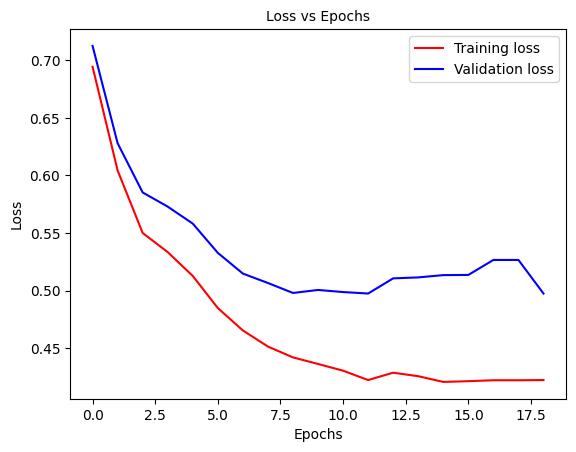

wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Run num_lay_4 hid_lay_size_32 activ_relu wt_init_He Opt_momentumlrn_rate_0.0001


wandb: Agent Starting Run: nyhxvz0r with config:
wandb: 	batch_size: 64
wandb: 	const_hidden_layer_activation: sigmoid
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 32
wandb: 	epochs: 40
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: momentum


 35%|█████████████████████████████                                                      | 14/40 [00:10<00:19,  1.35it/s]

Early stopping at epoch:  14 reverting to epoch  9


 35%|█████████████████████████████                                                      | 14/40 [00:11<00:21,  1.21it/s]


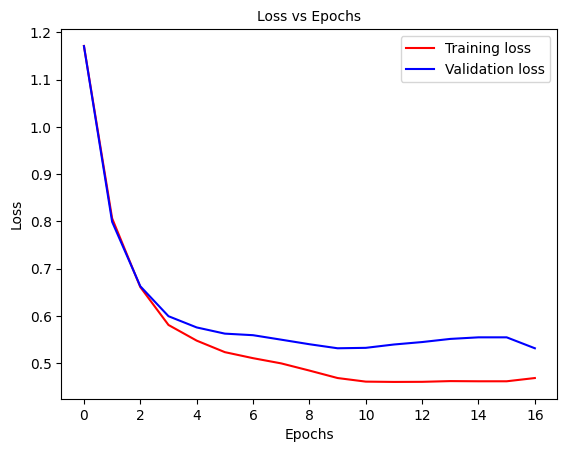

Run num_lay_4 hid_lay_size_32 activ_sigmoid wt_init_He Opt_momentumlrn_rate_0.001


wandb: Agent Starting Run: 2nin1896 with config:
wandb: 	batch_size: 128
wandb: 	const_hidden_layer_activation: sigmoid
wandb: 	const_hidden_layer_initializations: random
wandb: 	const_hidden_layer_size: 16
wandb: 	epochs: 40
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: nesterov


 72%|████████████████████████████████████████████████████████████▏                      | 29/40 [00:09<00:03,  3.10it/s]

Early stopping at epoch:  29 reverting to epoch  24


 72%|████████████████████████████████████████████████████████████▏                      | 29/40 [00:09<00:03,  2.92it/s]


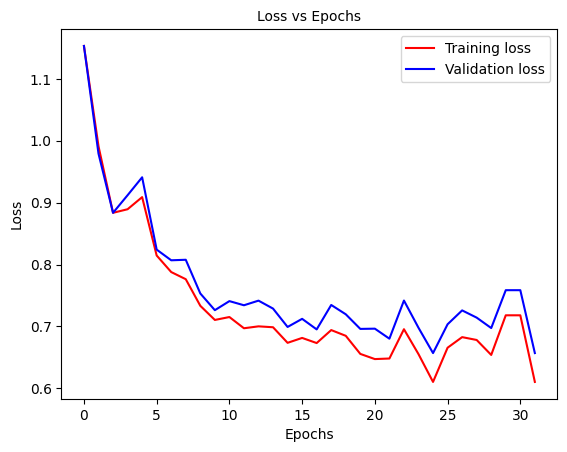

Run num_lay_3 hid_lay_size_16 activ_sigmoid wt_init_random Opt_nesterovlrn_rate_0.01


wandb: Agent Starting Run: geuamduq with config:
wandb: 	batch_size: 32
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: random
wandb: 	const_hidden_layer_size: 128
wandb: 	epochs: 20
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: momentum


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:37<00:00,  1.90s/it]


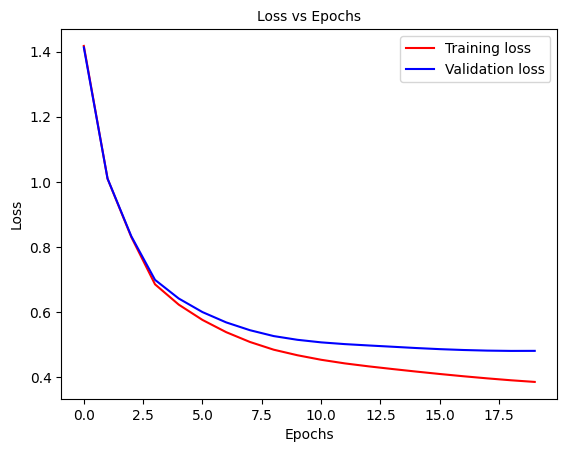

Run num_lay_4 hid_lay_size_128 activ_tanh wt_init_random Opt_momentumlrn_rate_0.0001


wandb: Agent Starting Run: medo5ry1 with config:
wandb: 	batch_size: 64
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 128
wandb: 	epochs: 20
wandb: 	lamdba: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: adam


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:44<00:00,  2.23s/it]


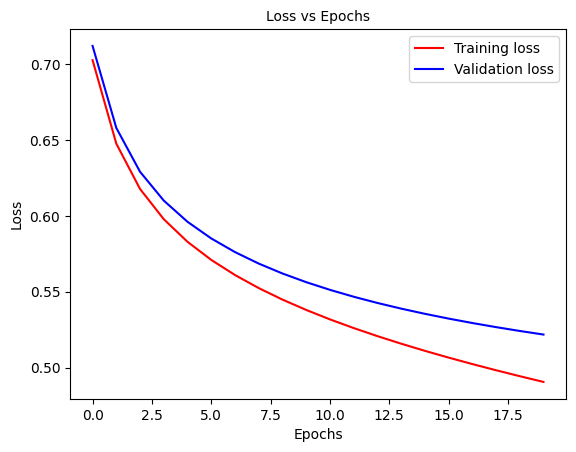

Run num_lay_5 hid_lay_size_128 activ_tanh wt_init_xavier Opt_adamlrn_rate_0.0001


wandb: Agent Starting Run: 3pm55ncm with config:
wandb: 	batch_size: 64
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: random
wandb: 	const_hidden_layer_size: 16
wandb: 	epochs: 10
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: rmsprop


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.29it/s]


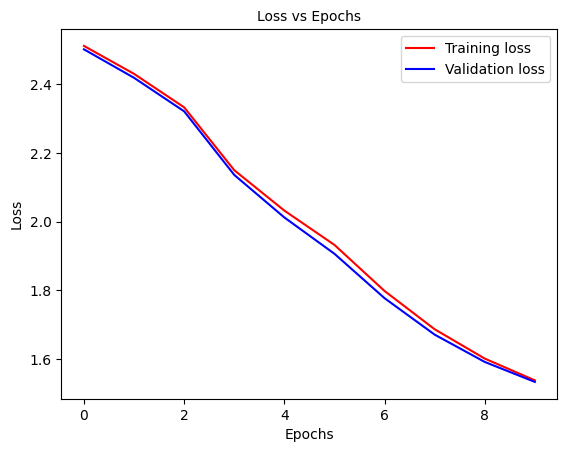

Run num_lay_3 hid_lay_size_16 activ_tanh wt_init_random Opt_rmsproplrn_rate_0.0001


wandb: Agent Starting Run: tb481cwo with config:
wandb: 	batch_size: 256
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: random
wandb: 	const_hidden_layer_size: 16
wandb: 	epochs: 10
wandb: 	lamdba: 0.5
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: batch


 50%|██████████████████████████████████████████                                          | 5/10 [00:00<00:00,  5.18it/s]

Early stopping at epoch:  5 reverting to epoch  0


 50%|██████████████████████████████████████████                                          | 5/10 [00:01<00:01,  3.64it/s]


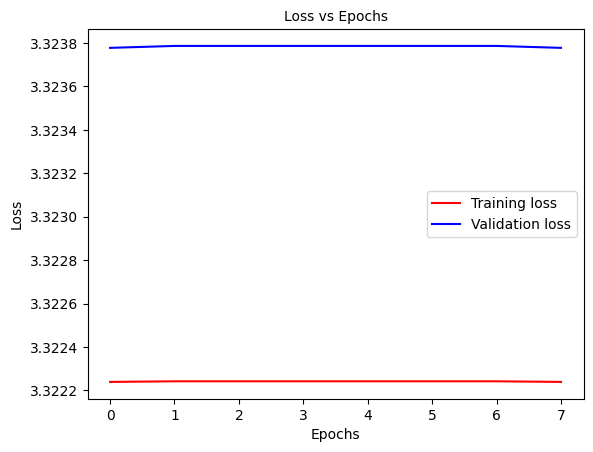

Run num_lay_3 hid_lay_size_16 activ_relu wt_init_random Opt_batchlrn_rate_0.001


wandb: Agent Starting Run: 5c4b2llc with config:
wandb: 	batch_size: 64
wandb: 	const_hidden_layer_activation: sigmoid
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 64
wandb: 	epochs: 30
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: rmsprop


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:40<00:00,  1.35s/it]


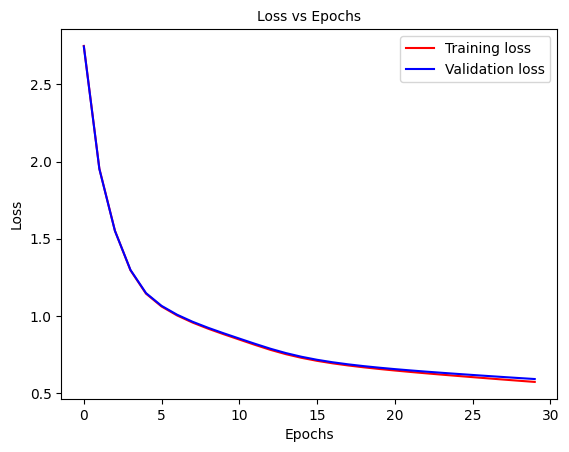

Run num_lay_4 hid_lay_size_64 activ_sigmoid wt_init_He Opt_rmsproplrn_rate_0.0001


wandb: Agent Starting Run: 4xc9qmc5 with config:
wandb: 	batch_size: 128
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: random
wandb: 	const_hidden_layer_size: 128
wandb: 	epochs: 10
wandb: 	lamdba: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: adam


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.16s/it]


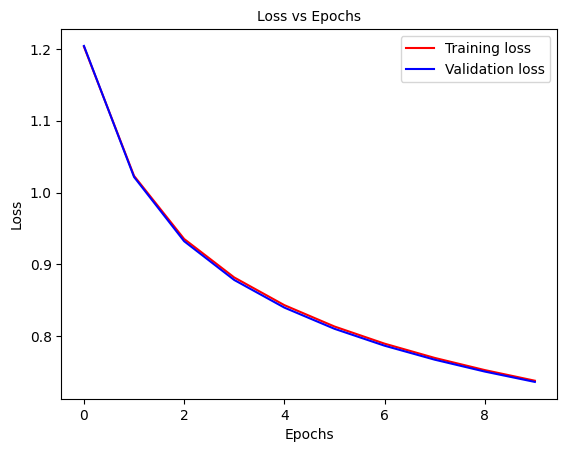

Run num_lay_3 hid_lay_size_128 activ_tanh wt_init_random Opt_adamlrn_rate_0.0001


wandb: Agent Starting Run: dvynmz5p with config:
wandb: 	batch_size: 128
wandb: 	const_hidden_layer_activation: sigmoid
wandb: 	const_hidden_layer_initializations: random
wandb: 	const_hidden_layer_size: 512
wandb: 	epochs: 30
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: nadam


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [08:04<00:00, 16.15s/it]


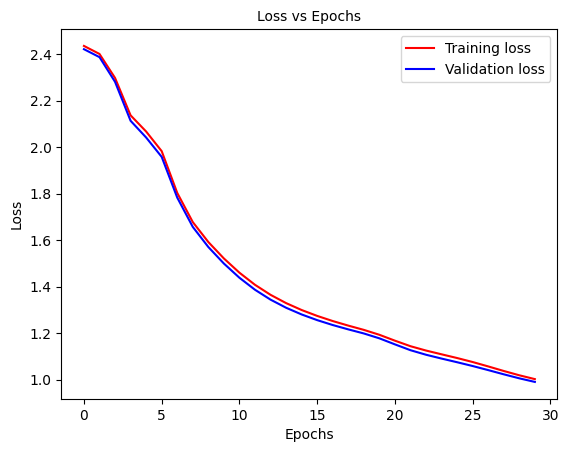

Run num_lay_5 hid_lay_size_512 activ_sigmoid wt_init_random Opt_nadamlrn_rate_0.0001


wandb: Agent Starting Run: 5ulnk7k8 with config:
wandb: 	batch_size: 32
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 256
wandb: 	epochs: 10
wandb: 	lamdba: 0.5
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 6
wandb: 	optimizer: batch


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:43<00:00,  4.33s/it]


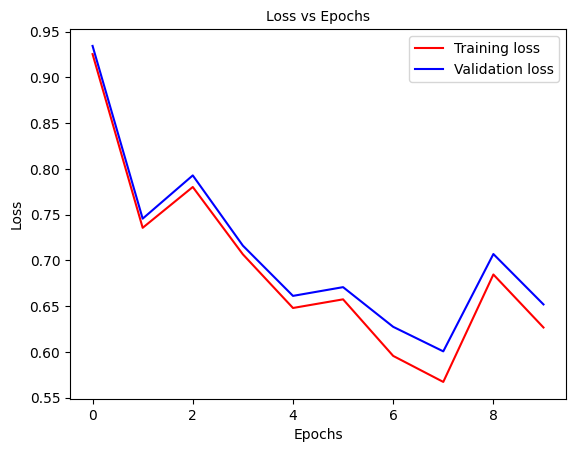

Run num_lay_6 hid_lay_size_256 activ_relu wt_init_He Opt_batchlrn_rate_0.01


wandb: Agent Starting Run: 1n60tdd9 with config:
wandb: 	batch_size: 64
wandb: 	const_hidden_layer_activation: sigmoid
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 32
wandb: 	epochs: 20
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: nesterov


 75%|██████████████████████████████████████████████████████████████▎                    | 15/20 [00:09<00:03,  1.59it/s]

Early stopping at epoch:  15 reverting to epoch  10


 75%|██████████████████████████████████████████████████████████████▎                    | 15/20 [00:10<00:03,  1.43it/s]


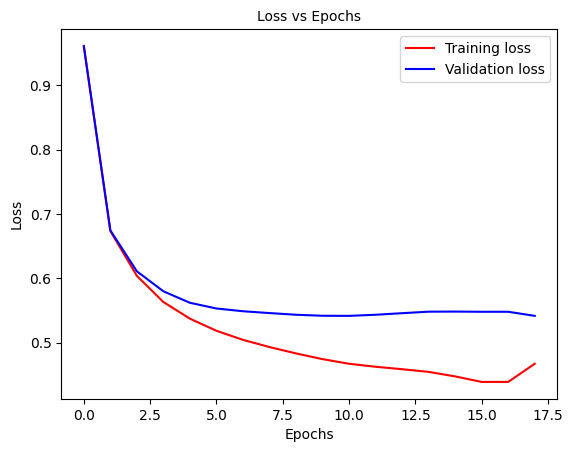

Run num_lay_3 hid_lay_size_32 activ_sigmoid wt_init_xavier Opt_nesterovlrn_rate_0.001


wandb: Agent Starting Run: zd00x46m with config:
wandb: 	batch_size: 32
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: random
wandb: 	const_hidden_layer_size: 64
wandb: 	epochs: 40
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: batch


 12%|██████████▌                                                                         | 5/40 [00:05<00:35,  1.02s/it]

Early stopping at epoch:  5 reverting to epoch  0


 12%|██████████▌                                                                         | 5/40 [00:06<00:45,  1.31s/it]


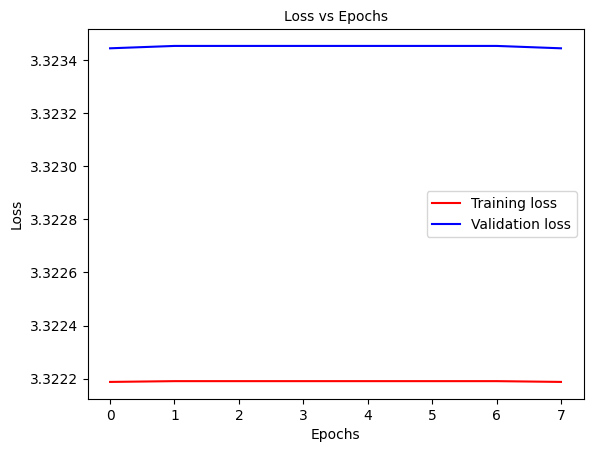

Run num_lay_5 hid_lay_size_64 activ_relu wt_init_random Opt_batchlrn_rate_0.001


wandb: Agent Starting Run: 97cq7hxd with config:
wandb: 	batch_size: 256
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 64
wandb: 	epochs: 30
wandb: 	lamdba: 0.5
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 6
wandb: 	optimizer: rmsprop


 40%|█████████████████████████████████▏                                                 | 12/30 [00:06<00:10,  1.79it/s]

Early stopping at epoch:  12 reverting to epoch  7


 40%|█████████████████████████████████▏                                                 | 12/30 [00:07<00:11,  1.55it/s]


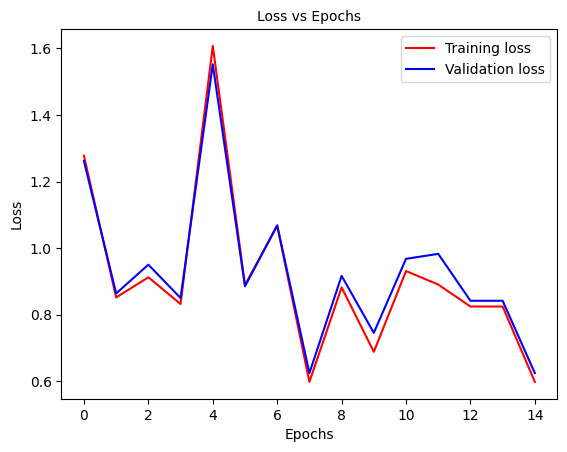

Run num_lay_6 hid_lay_size_64 activ_relu wt_init_He Opt_rmsproplrn_rate_0.01


wandb: Agent Starting Run: sy5vdxtk with config:
wandb: 	batch_size: 256
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 64
wandb: 	epochs: 20
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: batch


 75%|██████████████████████████████████████████████████████████████▎                    | 15/20 [00:08<00:02,  1.70it/s]

Early stopping at epoch:  15 reverting to epoch  10


 75%|██████████████████████████████████████████████████████████████▎                    | 15/20 [00:10<00:03,  1.49it/s]


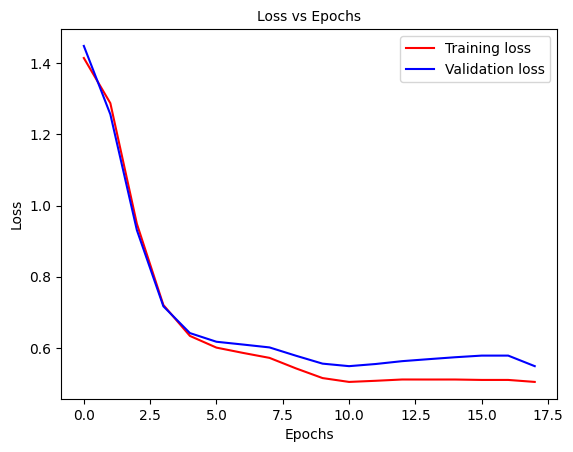

Run num_lay_5 hid_lay_size_64 activ_tanh wt_init_xavier Opt_batchlrn_rate_0.001


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q2tluhqg with config:
wandb: 	batch_size: 128
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 256
wandb: 	epochs: 10
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: batch


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:22<00:00,  2.23s/it]


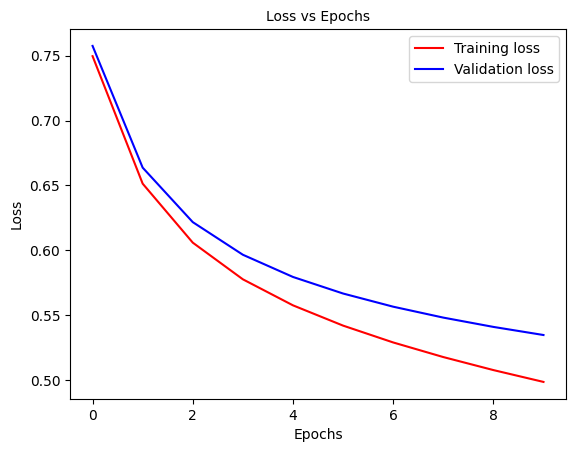

Run num_lay_4 hid_lay_size_256 activ_tanh wt_init_He Opt_batchlrn_rate_0.0001


wandb: Agent Starting Run: kia2wo8e with config:
wandb: 	batch_size: 64
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 16
wandb: 	epochs: 30
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam


 87%|███████████████████████████████████████████████████████████████████████▉           | 26/30 [00:11<00:01,  2.26it/s]

Early stopping at epoch:  26 reverting to epoch  21


 87%|███████████████████████████████████████████████████████████████████████▉           | 26/30 [00:12<00:01,  2.13it/s]


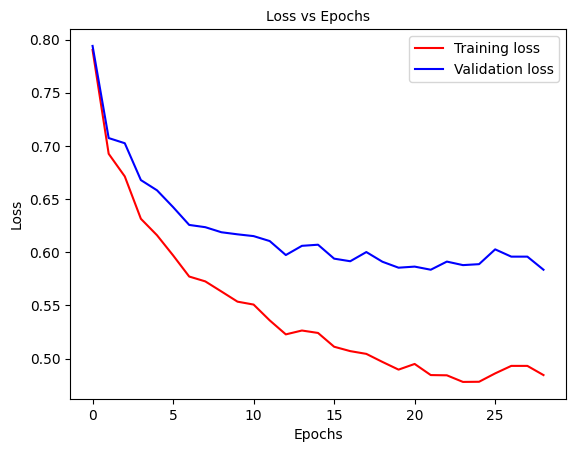

Run num_lay_5 hid_lay_size_16 activ_tanh wt_init_He Opt_adamlrn_rate_0.01


wandb: Agent Starting Run: e3f433sd with config:
wandb: 	batch_size: 32
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 16
wandb: 	epochs: 20
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: batch


 25%|█████████████████████                                                               | 5/20 [00:02<00:06,  2.47it/s]

Early stopping at epoch:  5 reverting to epoch  0


 25%|█████████████████████                                                               | 5/20 [00:02<00:07,  1.88it/s]


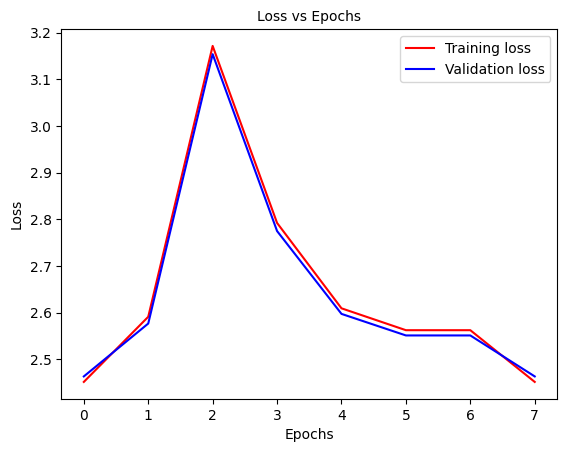

Run num_lay_5 hid_lay_size_16 activ_relu wt_init_xavier Opt_batchlrn_rate_0.01


wandb: Agent Starting Run: jqtm41rl with config:
wandb: 	batch_size: 256
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 16
wandb: 	epochs: 20
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 4
wandb: 	optimizer: momentum


 25%|█████████████████████                                                               | 5/20 [00:01<00:03,  4.77it/s]

Early stopping at epoch:  5 reverting to epoch  0


 25%|█████████████████████                                                               | 5/20 [00:01<00:04,  3.41it/s]


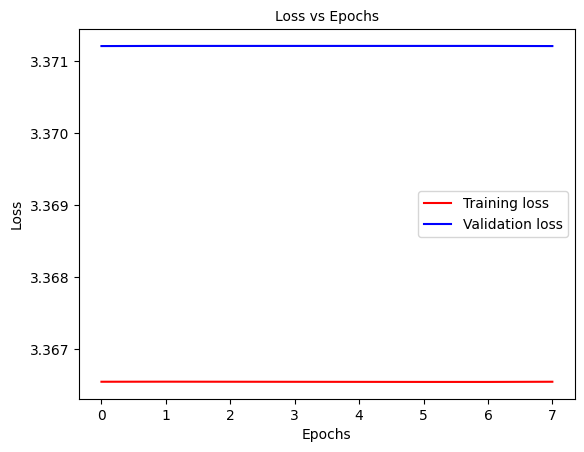

Run num_lay_4 hid_lay_size_16 activ_relu wt_init_He Opt_momentumlrn_rate_0.01


wandb: Agent Starting Run: baw1zkvz with config:
wandb: 	batch_size: 256
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 256
wandb: 	epochs: 20
wandb: 	lamdba: 0.5
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam


 90%|██████████████████████████████████████████████████████████████████████████▋        | 18/20 [00:37<00:04,  2.11s/it]

Early stopping at epoch:  18 reverting to epoch  13


 90%|██████████████████████████████████████████████████████████████████████████▋        | 18/20 [00:41<00:04,  2.29s/it]


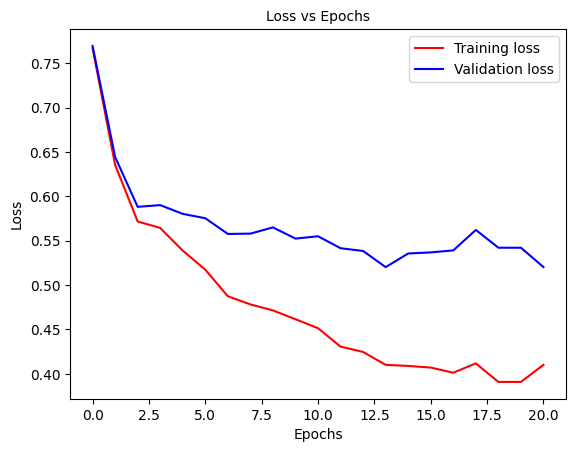

Run num_lay_3 hid_lay_size_256 activ_tanh wt_init_xavier Opt_adamlrn_rate_0.01


wandb: Agent Starting Run: 6q74wc68 with config:
wandb: 	batch_size: 256
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: random
wandb: 	const_hidden_layer_size: 16
wandb: 	epochs: 20
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: batch


 25%|█████████████████████                                                               | 5/20 [00:01<00:03,  4.40it/s]

Early stopping at epoch:  5 reverting to epoch  0


 25%|█████████████████████                                                               | 5/20 [00:01<00:04,  3.11it/s]


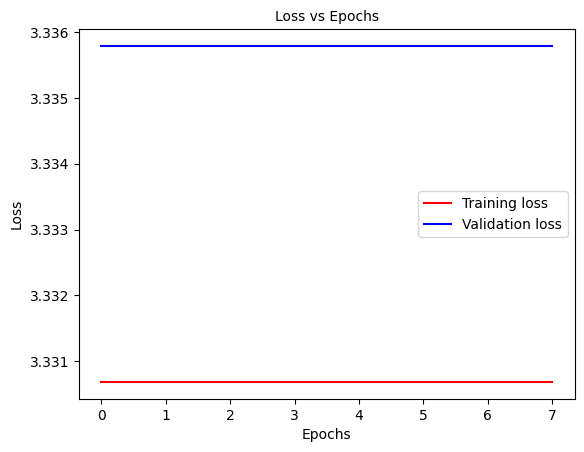

Run num_lay_5 hid_lay_size_16 activ_relu wt_init_random Opt_batchlrn_rate_0.01


wandb: Agent Starting Run: cxz7e8i1 with config:
wandb: 	batch_size: 64
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: random
wandb: 	const_hidden_layer_size: 32
wandb: 	epochs: 10
wandb: 	lamdba: 0.5
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: nesterov


 50%|██████████████████████████████████████████                                          | 5/10 [00:02<00:02,  1.82it/s]

Early stopping at epoch:  5 reverting to epoch  0


 50%|██████████████████████████████████████████                                          | 5/10 [00:03<00:03,  1.40it/s]


Run num_lay_5 hid_lay_size_32 activ_relu wt_init_random Opt_nesterovlrn_rate_0.001


wandb: Agent Starting Run: u0sv8ozs with config:
wandb: 	batch_size: 256
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: random
wandb: 	const_hidden_layer_size: 256
wandb: 	epochs: 10
wandb: 	lamdba: 0.5
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 6
wandb: 	optimizer: batch


 50%|██████████████████████████████████████████                                          | 5/10 [00:10<00:10,  2.19s/it]

Early stopping at epoch:  5 reverting to epoch  0


 50%|██████████████████████████████████████████                                          | 5/10 [00:14<00:14,  2.92s/it]


Run num_lay_6 hid_lay_size_256 activ_relu wt_init_random Opt_batchlrn_rate_0.001


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5k2hydn7 with config:
wandb: 	batch_size: 64
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: random
wandb: 	const_hidden_layer_size: 256
wandb: 	epochs: 40
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 6
wandb: 	optimizer: nadam


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [04:34<00:00,  6.87s/it]


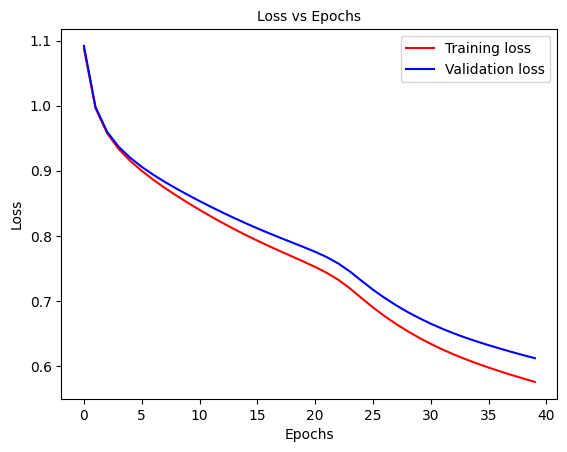

Run num_lay_6 hid_lay_size_256 activ_tanh wt_init_random Opt_nadamlrn_rate_0.0001


wandb: Agent Starting Run: c12xxw7g with config:
wandb: 	batch_size: 64
wandb: 	const_hidden_layer_activation: sigmoid
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 32
wandb: 	epochs: 30
wandb: 	lamdba: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: batch


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:17<00:00,  1.74it/s]


Run num_lay_3 hid_lay_size_32 activ_sigmoid wt_init_He Opt_batchlrn_rate_0.0001


wandb: Agent Starting Run: hqrejnch with config:
wandb: 	batch_size: 64
wandb: 	const_hidden_layer_activation: sigmoid
wandb: 	const_hidden_layer_initializations: random
wandb: 	const_hidden_layer_size: 32
wandb: 	epochs: 30
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: nadam


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:27<00:00,  1.08it/s]


Run num_lay_4 hid_lay_size_32 activ_sigmoid wt_init_random Opt_nadamlrn_rate_0.001


wandb: Agent Starting Run: 5tyqdyk4 with config:
wandb: 	batch_size: 128
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: random
wandb: 	const_hidden_layer_size: 256
wandb: 	epochs: 10
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 4
wandb: 	optimizer: nesterov


 80%|███████████████████████████████████████████████████████████████████▏                | 8/10 [00:20<00:05,  2.54s/it]

Early stopping at epoch:  8 reverting to epoch  3


 80%|███████████████████████████████████████████████████████████████████▏                | 8/10 [00:24<00:06,  3.04s/it]


Run num_lay_4 hid_lay_size_256 activ_tanh wt_init_random Opt_nesterovlrn_rate_0.01


wandb: Agent Starting Run: xs88p0gq with config:
wandb: 	batch_size: 128
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 64
wandb: 	epochs: 40
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: rmsprop


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.97it/s]


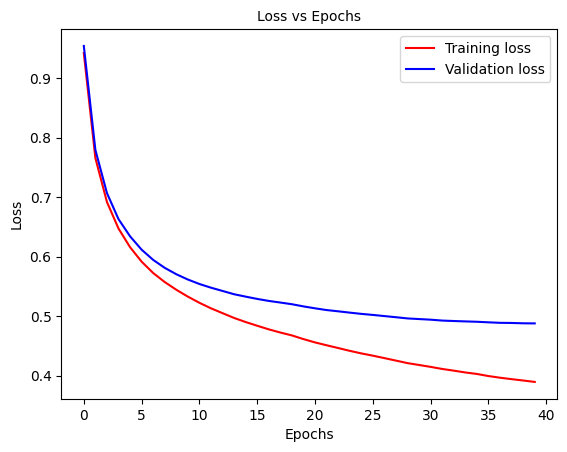

Run num_lay_3 hid_lay_size_64 activ_relu wt_init_He Opt_rmsproplrn_rate_0.0001


wandb: Agent Starting Run: g6ma4z1q with config:
wandb: 	batch_size: 64
wandb: 	const_hidden_layer_activation: sigmoid
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 512
wandb: 	epochs: 30
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: adam


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [08:31<00:00, 17.06s/it]


Run num_lay_4 hid_lay_size_512 activ_sigmoid wt_init_He Opt_adamlrn_rate_0.0001


wandb: Agent Starting Run: zgv1y190 with config:
wandb: 	batch_size: 256
wandb: 	const_hidden_layer_activation: sigmoid
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 16
wandb: 	epochs: 20
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 6
wandb: 	optimizer: nadam


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.08it/s]


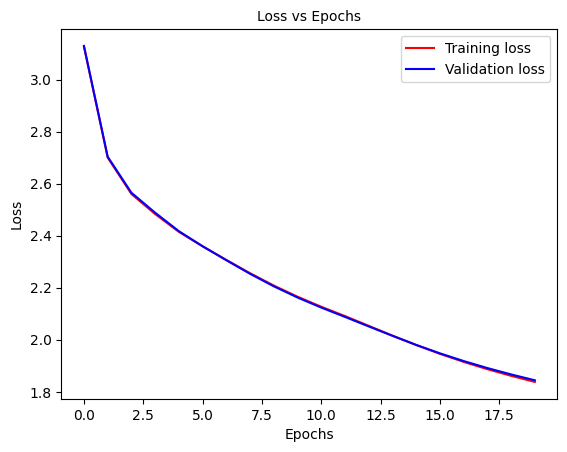

Run num_lay_6 hid_lay_size_16 activ_sigmoid wt_init_He Opt_nadamlrn_rate_0.001


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y6u9biwp with config:
wandb: 	batch_size: 64
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 32
wandb: 	epochs: 10
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: momentum


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.88it/s]


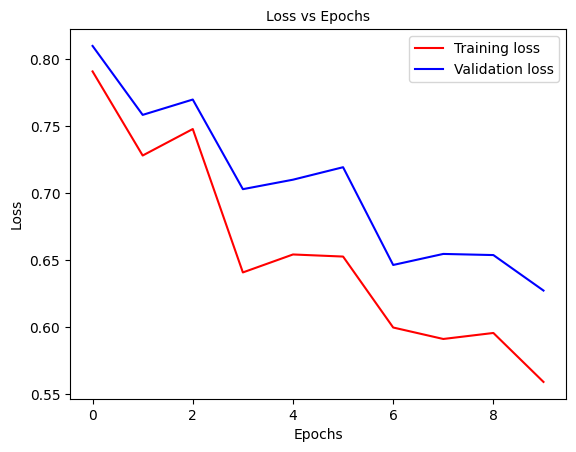

Run num_lay_5 hid_lay_size_32 activ_relu wt_init_xavier Opt_momentumlrn_rate_0.001


wandb: Agent Starting Run: 6ihyfip4 with config:
wandb: 	batch_size: 32
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: random
wandb: 	const_hidden_layer_size: 32
wandb: 	epochs: 30
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: momentum


 20%|████████████████▊                                                                   | 6/30 [00:03<00:12,  1.97it/s]

Early stopping at epoch:  6 reverting to epoch  1


 20%|████████████████▊                                                                   | 6/30 [00:03<00:15,  1.57it/s]


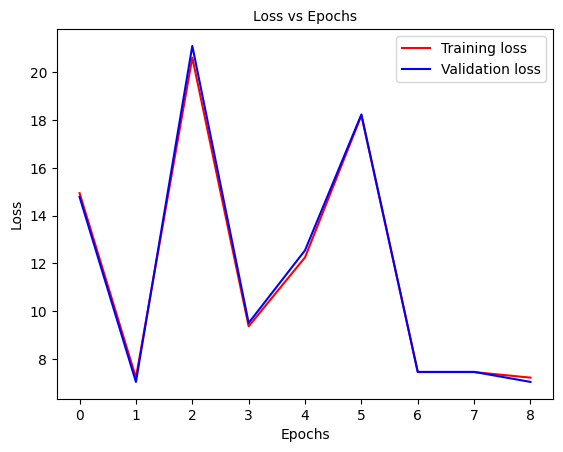

Run num_lay_3 hid_lay_size_32 activ_tanh wt_init_random Opt_momentumlrn_rate_0.01


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: k93s86yr with config:
wandb: 	batch_size: 256
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 32
wandb: 	epochs: 10
wandb: 	lamdba: 0.5
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 6
wandb: 	optimizer: nesterov


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.30it/s]


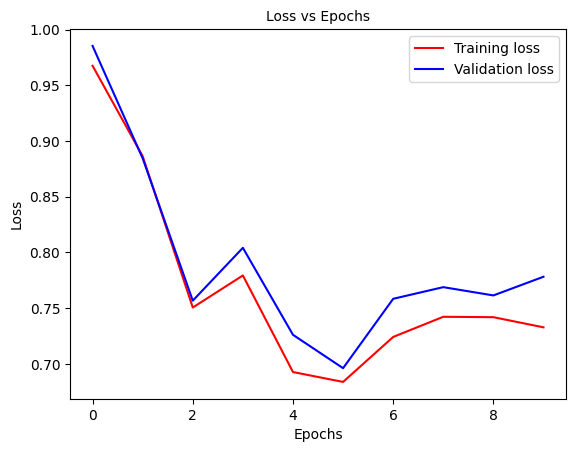

Run num_lay_6 hid_lay_size_32 activ_tanh wt_init_He Opt_nesterovlrn_rate_0.001


wandb: Agent Starting Run: jxkwoj5d with config:
wandb: 	batch_size: 32
wandb: 	const_hidden_layer_activation: sigmoid
wandb: 	const_hidden_layer_initializations: random
wandb: 	const_hidden_layer_size: 64
wandb: 	epochs: 10
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 6
wandb: 	optimizer: adam


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:26<00:00,  2.65s/it]


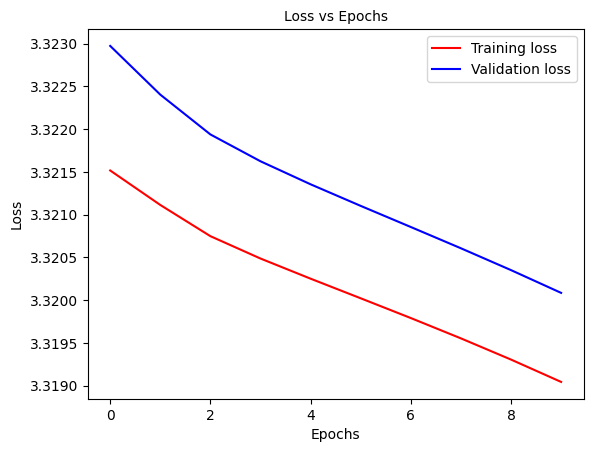

Run num_lay_6 hid_lay_size_64 activ_sigmoid wt_init_random Opt_adamlrn_rate_0.0001


wandb: Agent Starting Run: bcal1a0l with config:
wandb: 	batch_size: 128
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 32
wandb: 	epochs: 10
wandb: 	lamdba: 0.5
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 6
wandb: 	optimizer: nadam


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.60it/s]


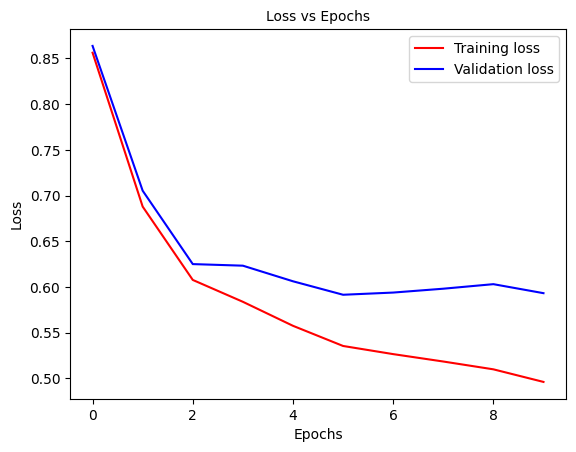

Run num_lay_6 hid_lay_size_32 activ_tanh wt_init_He Opt_nadamlrn_rate_0.01


wandb: Agent Starting Run: sxes66vk with config:
wandb: 	batch_size: 256
wandb: 	const_hidden_layer_activation: sigmoid
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 32
wandb: 	epochs: 40
wandb: 	lamdba: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [00:17<00:00,  2.24it/s]


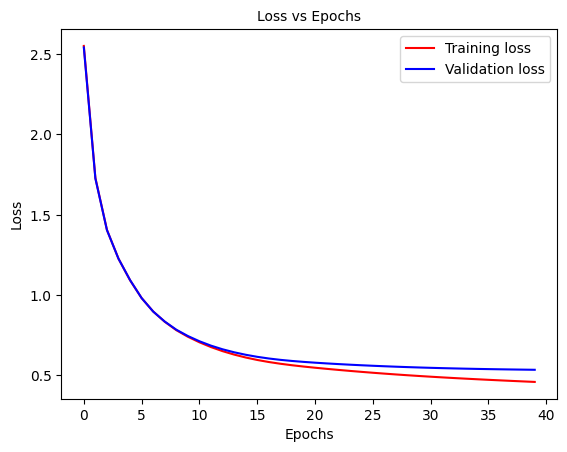

Run num_lay_3 hid_lay_size_32 activ_sigmoid wt_init_He Opt_momentumlrn_rate_0.0001


wandb: Agent Starting Run: dzdrefz8 with config:
wandb: 	batch_size: 256
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 128
wandb: 	epochs: 10
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 6
wandb: 	optimizer: momentum


  0%|                                                                                            | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_2806300/3245883194.py:43: RuntimeWarning: overflow encountered in matmul
  self.a=self.b+np.matmul(self.W,inputs)
/tmp/ipykernel_2806300/3245883194.py:43: RuntimeWarning: invalid value encountered in matmul
  self.a=self.b+np.matmul(self.W,inputs)
/tmp/ipykernel_2806300/3907448899.py:46: RuntimeWarning: overflow encountered in matmul
  self.layers[idx-1].d_h=np.matmul(np.transpose(self.layers[idx].W),self.layers[idx].d_a)
/tmp/ipykernel_2806300/3907448899.py:49: RuntimeWarning: invalid value encountered in multiply
  self.layers[idx-1].d_a=self.layers[idx-1].d_h*self.layers[idx-1].d_g(self.layers[idx-1].a)
/tmp/ipykernel_2806300/1612105026.py:114: RuntimeWarning: overflow encountered in square
  regularization=1/2*self.model.lamdba_m*np.sum([np.sum(layer.W**2) for layer in self.model.layers])
 50%|██████████████████████████████████████████              

Early stopping at epoch:  5 reverting to epoch  0


 50%|██████████████████████████████████████████                                          | 5/10 [00:06<00:06,  1.24s/it]


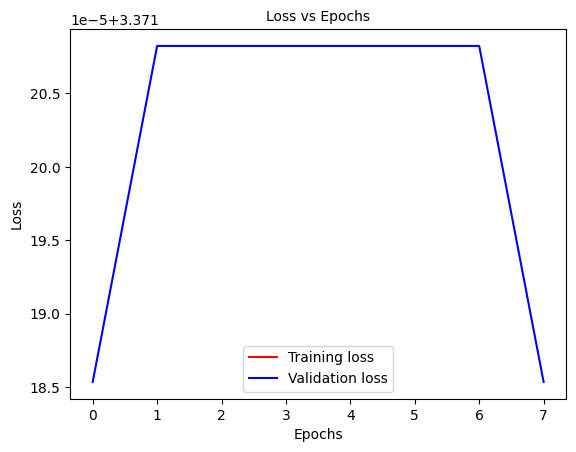

Run num_lay_6 hid_lay_size_128 activ_relu wt_init_xavier Opt_momentumlrn_rate_0.01


wandb: Agent Starting Run: v97ixhj5 with config:
wandb: 	batch_size: 64
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: random
wandb: 	const_hidden_layer_size: 512
wandb: 	epochs: 40
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam


 40%|█████████████████████████████████▏                                                 | 16/40 [04:24<06:35, 16.48s/it]

Early stopping at epoch:  16 reverting to epoch  11


 40%|█████████████████████████████████▏                                                 | 16/40 [04:44<07:06, 17.75s/it]


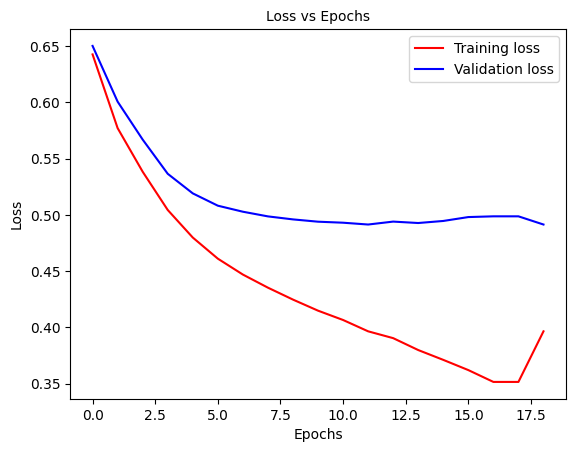

Run num_lay_5 hid_lay_size_512 activ_tanh wt_init_random Opt_adamlrn_rate_0.001


wandb: Agent Starting Run: f7qx0fe7 with config:
wandb: 	batch_size: 32
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 128
wandb: 	epochs: 40
wandb: 	lamdba: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 6
wandb: 	optimizer: batch


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [01:29<00:00,  2.23s/it]


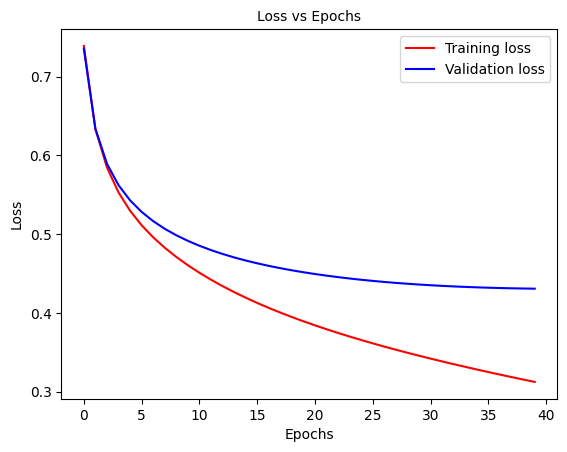

Run num_lay_6 hid_lay_size_128 activ_tanh wt_init_He Opt_batchlrn_rate_0.0001


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9humib1d with config:
wandb: 	batch_size: 32
wandb: 	const_hidden_layer_activation: sigmoid
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 64
wandb: 	epochs: 30
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: nesterov


 40%|█████████████████████████████████▏                                                 | 12/30 [00:15<00:23,  1.29s/it]

Early stopping at epoch:  12 reverting to epoch  7


 40%|█████████████████████████████████▏                                                 | 12/30 [00:17<00:26,  1.45s/it]


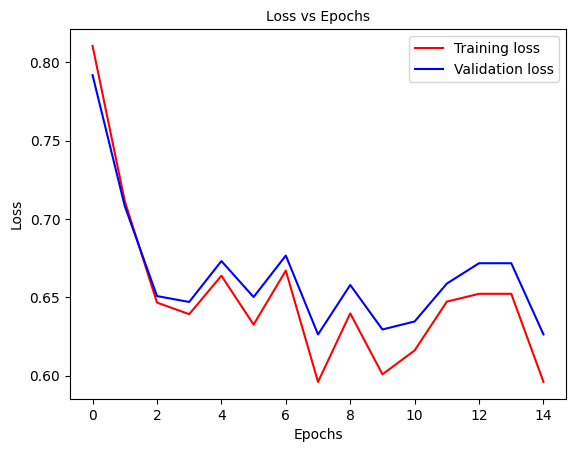

Run num_lay_3 hid_lay_size_64 activ_sigmoid wt_init_xavier Opt_nesterovlrn_rate_0.01


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mhh3fjn3 with config:
wandb: 	batch_size: 128
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: random
wandb: 	const_hidden_layer_size: 16
wandb: 	epochs: 10
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: nadam


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.64it/s]


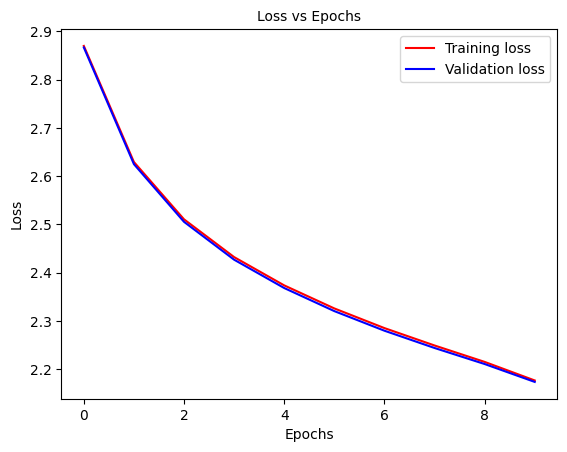

Run num_lay_4 hid_lay_size_16 activ_relu wt_init_random Opt_nadamlrn_rate_0.0001


wandb: Agent Starting Run: 1ifk8otr with config:
wandb: 	batch_size: 64
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 32
wandb: 	epochs: 20
wandb: 	lamdba: 0.5
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: nadam


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.23it/s]


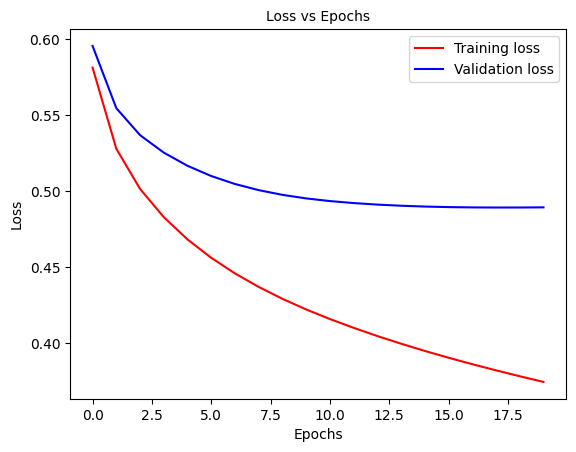

Run num_lay_5 hid_lay_size_32 activ_tanh wt_init_He Opt_nadamlrn_rate_0.001


wandb: Agent Starting Run: wttiy00h with config:
wandb: 	batch_size: 128
wandb: 	const_hidden_layer_activation: sigmoid
wandb: 	const_hidden_layer_initializations: random
wandb: 	const_hidden_layer_size: 128
wandb: 	epochs: 40
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam


 48%|███████████████████████████████████████▍                                           | 19/40 [00:33<00:37,  1.78s/it]

Early stopping at epoch:  19 reverting to epoch  14


 48%|███████████████████████████████████████▍                                           | 19/40 [00:36<00:40,  1.92s/it]


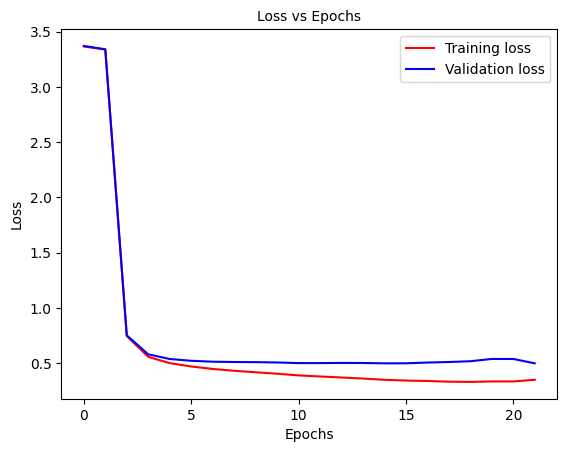

Run num_lay_3 hid_lay_size_128 activ_sigmoid wt_init_random Opt_adamlrn_rate_0.01


wandb: Agent Starting Run: 9odzxg71 with config:
wandb: 	batch_size: 64
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 256
wandb: 	epochs: 10
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: nadam


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:41<00:00,  4.11s/it]


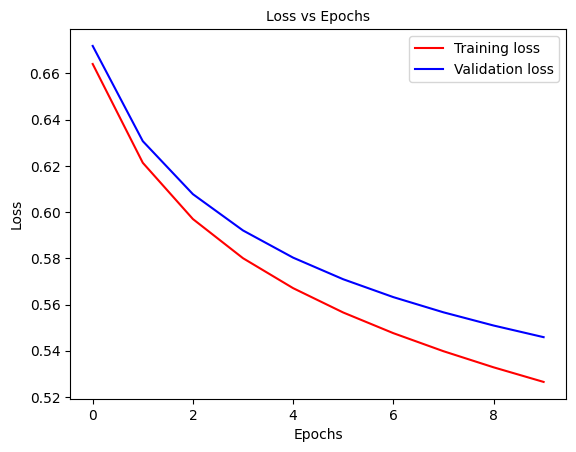

Run num_lay_3 hid_lay_size_256 activ_tanh wt_init_xavier Opt_nadamlrn_rate_0.0001


wandb: Agent Starting Run: 3wetbbat with config:
wandb: 	batch_size: 64
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 64
wandb: 	epochs: 20
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: nesterov


 85%|██████████████████████████████████████████████████████████████████████▌            | 17/20 [00:10<00:01,  1.60it/s]

Early stopping at epoch:  17 reverting to epoch  12


 85%|██████████████████████████████████████████████████████████████████████▌            | 17/20 [00:11<00:02,  1.48it/s]


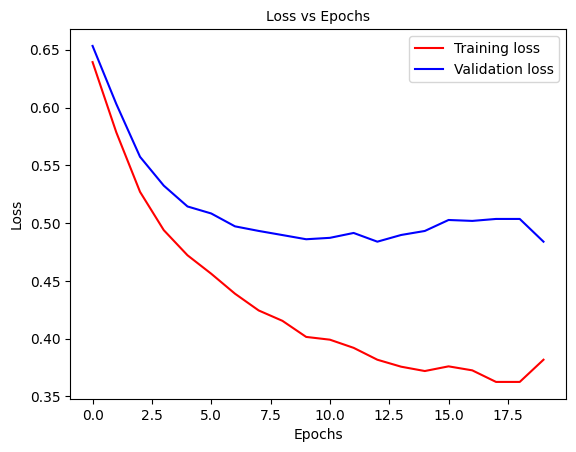

Run num_lay_3 hid_lay_size_64 activ_relu wt_init_xavier Opt_nesterovlrn_rate_0.0001


wandb: Agent Starting Run: 70ie9yrw with config:
wandb: 	batch_size: 32
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 16
wandb: 	epochs: 30
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: rmsprop


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:16<00:00,  1.85it/s]


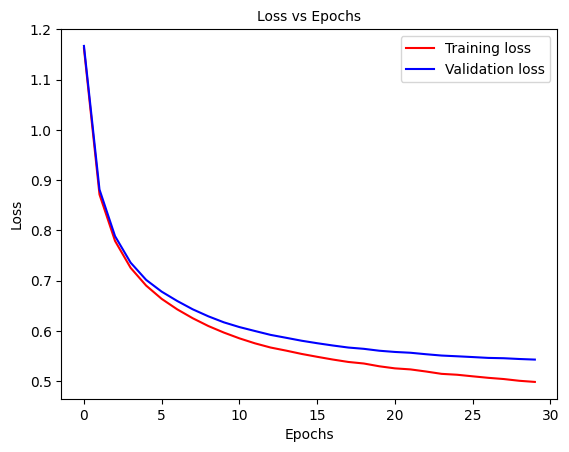

Run num_lay_5 hid_lay_size_16 activ_relu wt_init_He Opt_rmsproplrn_rate_0.0001


wandb: Agent Starting Run: k0wyi7zx with config:
wandb: 	batch_size: 64
wandb: 	const_hidden_layer_activation: sigmoid
wandb: 	const_hidden_layer_initializations: random
wandb: 	const_hidden_layer_size: 32
wandb: 	epochs: 40
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: momentum


 48%|███████████████████████████████████████▍                                           | 19/40 [00:11<00:12,  1.69it/s]

Early stopping at epoch:  19 reverting to epoch  14


 48%|███████████████████████████████████████▍                                           | 19/40 [00:12<00:13,  1.56it/s]


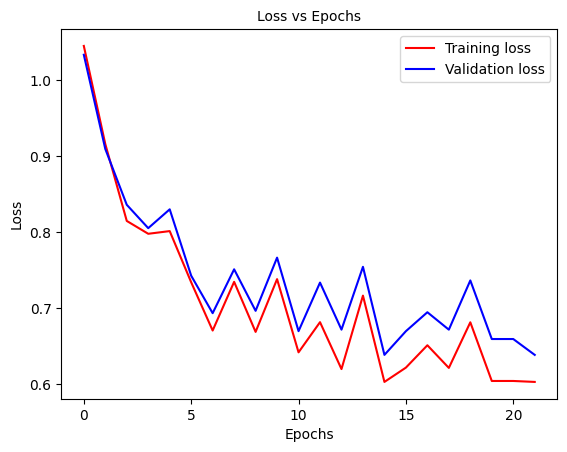

Run num_lay_3 hid_lay_size_32 activ_sigmoid wt_init_random Opt_momentumlrn_rate_0.01


wandb: Agent Starting Run: yg7dlm8g with config:
wandb: 	batch_size: 128
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 64
wandb: 	epochs: 20
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 6
wandb: 	optimizer: rmsprop


 35%|█████████████████████████████▍                                                      | 7/20 [00:05<00:10,  1.30it/s]

Early stopping at epoch:  7 reverting to epoch  2


 35%|█████████████████████████████▍                                                      | 7/20 [00:06<00:12,  1.07it/s]


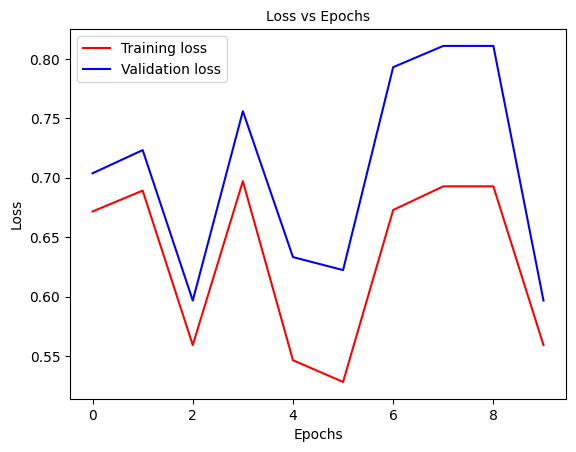

Run num_lay_6 hid_lay_size_64 activ_relu wt_init_He Opt_rmsproplrn_rate_0.001


wandb: Agent Starting Run: bu0a6j65 with config:
wandb: 	batch_size: 64
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 256
wandb: 	epochs: 30
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: nesterov


 47%|██████████████████████████████████████▋                                            | 14/30 [00:45<00:52,  3.26s/it]

Early stopping at epoch:  14 reverting to epoch  9


 47%|██████████████████████████████████████▋                                            | 14/30 [00:49<00:56,  3.55s/it]


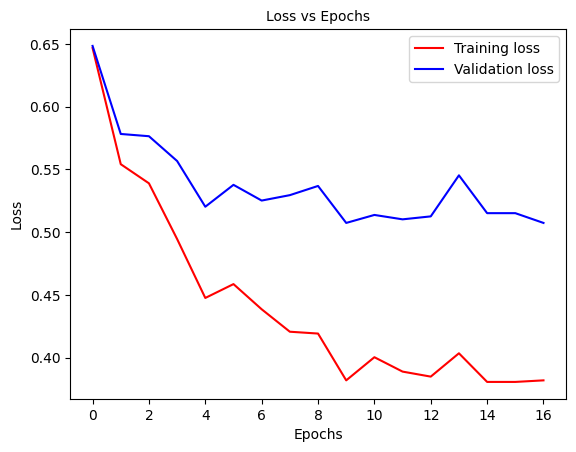

Run num_lay_4 hid_lay_size_256 activ_tanh wt_init_xavier Opt_nesterovlrn_rate_0.001


wandb: Agent Starting Run: 3ttc2elq with config:
wandb: 	batch_size: 128
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: random
wandb: 	const_hidden_layer_size: 16
wandb: 	epochs: 30
wandb: 	lamdba: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 6
wandb: 	optimizer: nadam


 17%|██████████████                                                                      | 5/30 [00:01<00:08,  3.00it/s]

Early stopping at epoch:  5 reverting to epoch  0


 17%|██████████████                                                                      | 5/30 [00:02<00:11,  2.22it/s]


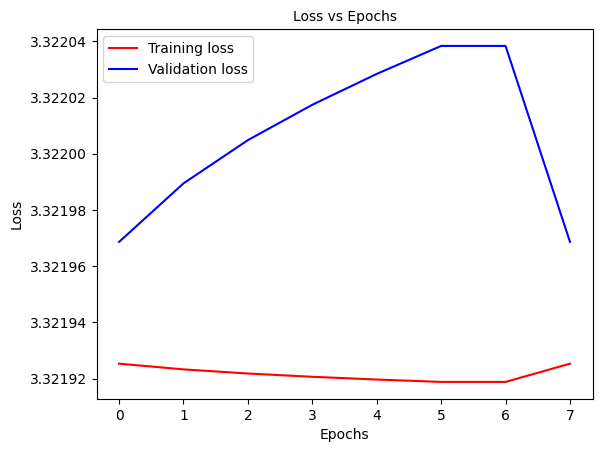

Run num_lay_6 hid_lay_size_16 activ_relu wt_init_random Opt_nadamlrn_rate_0.0001


wandb: Agent Starting Run: vh01km4z with config:
wandb: 	batch_size: 128
wandb: 	const_hidden_layer_activation: sigmoid
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 16
wandb: 	epochs: 30
wandb: 	lamdba: 0.5
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: rmsprop


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:12<00:00,  2.49it/s]


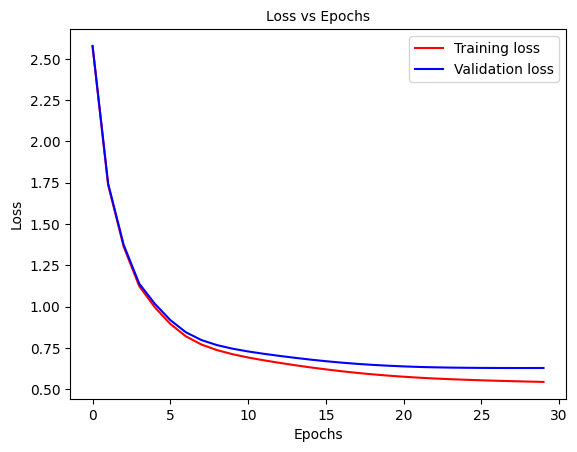

Run num_lay_4 hid_lay_size_16 activ_sigmoid wt_init_xavier Opt_rmsproplrn_rate_0.001


wandb: Agent Starting Run: kksxl8qx with config:
wandb: 	batch_size: 64
wandb: 	const_hidden_layer_activation: sigmoid
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 512
wandb: 	epochs: 20
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: nesterov


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [05:09<00:00, 15.46s/it]


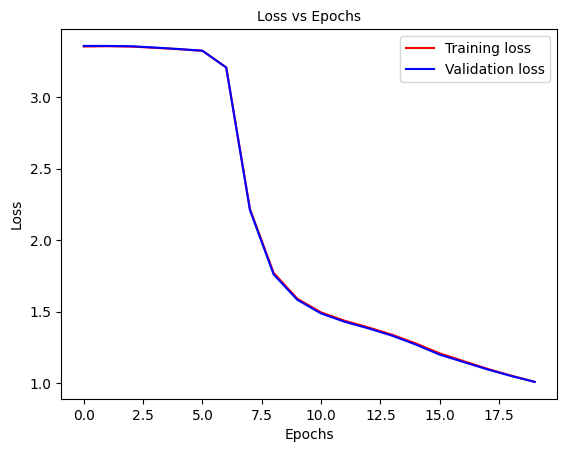

Run num_lay_5 hid_lay_size_512 activ_sigmoid wt_init_xavier Opt_nesterovlrn_rate_0.0001


wandb: Agent Starting Run: 36pbqv1t with config:
wandb: 	batch_size: 256
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 16
wandb: 	epochs: 30
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 4
wandb: 	optimizer: rmsprop


 40%|█████████████████████████████████▏                                                 | 12/30 [00:02<00:04,  4.22it/s]

Early stopping at epoch:  12 reverting to epoch  7


 40%|█████████████████████████████████▏                                                 | 12/30 [00:03<00:04,  3.63it/s]


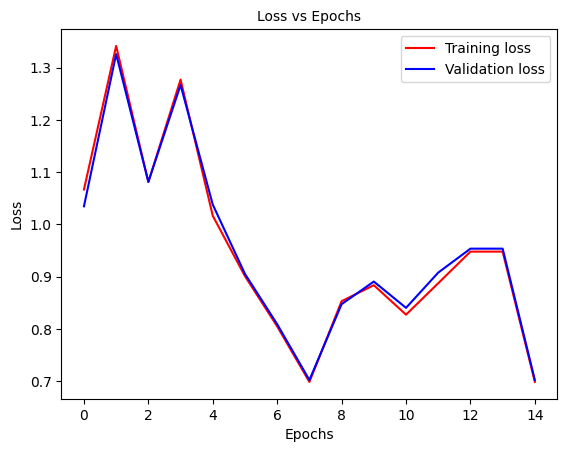

Run num_lay_4 hid_lay_size_16 activ_relu wt_init_He Opt_rmsproplrn_rate_0.01


wandb: Agent Starting Run: sx35cp1i with config:
wandb: 	batch_size: 32
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: random
wandb: 	const_hidden_layer_size: 256
wandb: 	epochs: 20
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: nadam


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [03:12<00:00,  9.61s/it]


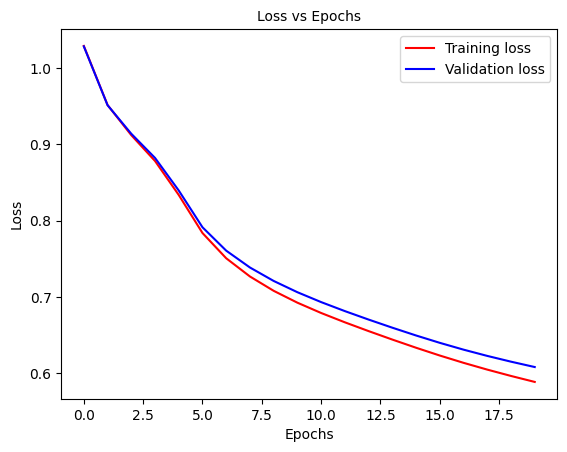

Run num_lay_5 hid_lay_size_256 activ_tanh wt_init_random Opt_nadamlrn_rate_0.0001


wandb: Agent Starting Run: tvug8yvr with config:
wandb: 	batch_size: 128
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 128
wandb: 	epochs: 30
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: momentum


 57%|███████████████████████████████████████████████                                    | 17/30 [00:16<00:13,  1.00s/it]

Early stopping at epoch:  17 reverting to epoch  12


 57%|███████████████████████████████████████████████                                    | 17/30 [00:18<00:14,  1.10s/it]


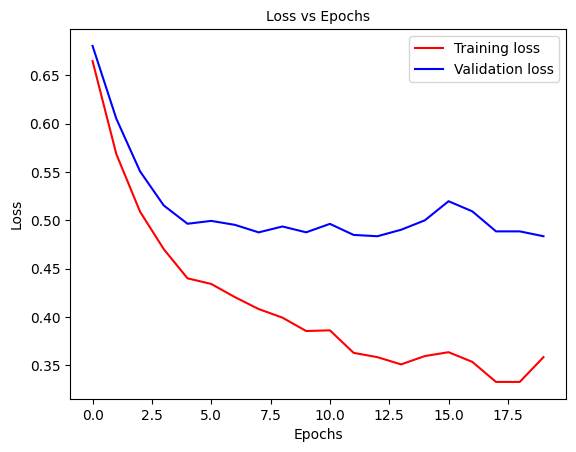

Run num_lay_4 hid_lay_size_128 activ_relu wt_init_xavier Opt_momentumlrn_rate_0.0001


wandb: Agent Starting Run: sxopk139 with config:
wandb: 	batch_size: 64
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 256
wandb: 	epochs: 10
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: rmsprop


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:28<00:00,  2.90s/it]


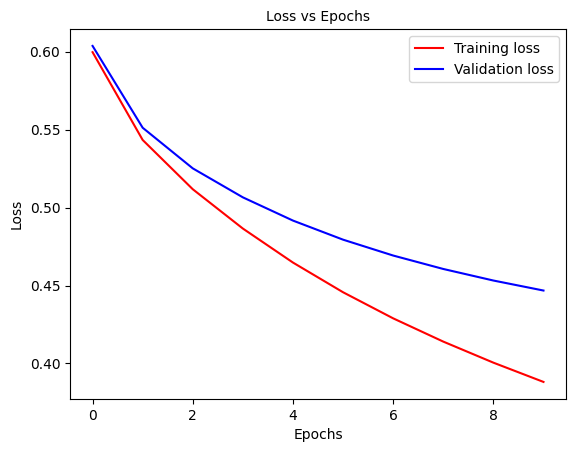

Run num_lay_3 hid_lay_size_256 activ_tanh wt_init_He Opt_rmsproplrn_rate_0.0001


wandb: Agent Starting Run: uvgdhkeo with config:
wandb: 	batch_size: 32
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 512
wandb: 	epochs: 20
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 6
wandb: 	optimizer: momentum


 60%|█████████████████████████████████████████████████▊                                 | 12/20 [03:40<02:26, 18.35s/it]

Early stopping at epoch:  12 reverting to epoch  7


 60%|█████████████████████████████████████████████████▊                                 | 12/20 [04:02<02:41, 20.24s/it]


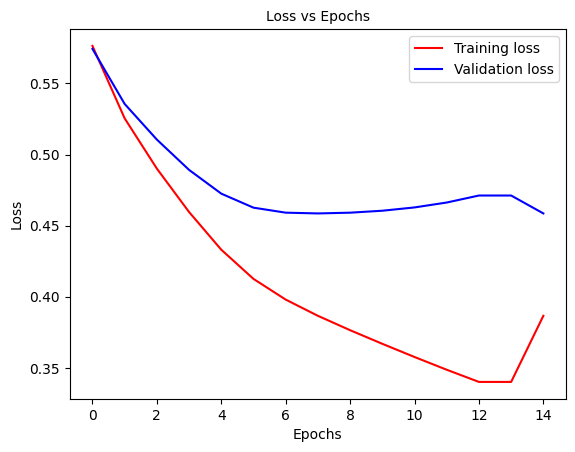

Run num_lay_6 hid_lay_size_512 activ_tanh wt_init_xavier Opt_momentumlrn_rate_0.0001


wandb: Agent Starting Run: h4p2pw4u with config:
wandb: 	batch_size: 128
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 16
wandb: 	epochs: 40
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: rmsprop


 28%|██████████████████████▊                                                            | 11/40 [00:02<00:07,  4.14it/s]

Early stopping at epoch:  11 reverting to epoch  6


 28%|██████████████████████▊                                                            | 11/40 [00:03<00:08,  3.51it/s]


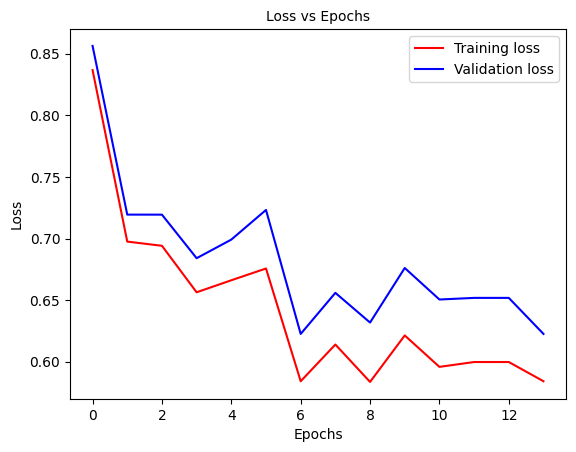

Run num_lay_3 hid_lay_size_16 activ_tanh wt_init_xavier Opt_rmsproplrn_rate_0.01


wandb: Agent Starting Run: mwse1x7z with config:
wandb: 	batch_size: 256
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 256
wandb: 	epochs: 10
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: momentum


  0%|                                                                                            | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_2806300/3245883194.py:43: RuntimeWarning: overflow encountered in matmul
  self.a=self.b+np.matmul(self.W,inputs)
/tmp/ipykernel_2806300/3245883194.py:43: RuntimeWarning: invalid value encountered in matmul
  self.a=self.b+np.matmul(self.W,inputs)
/tmp/ipykernel_2806300/1429278179.py:7: RuntimeWarning: invalid value encountered in subtract
  z=x-np.max(x,axis=0)
  0%|                                                                                            | 0/10 [00:01<?, ?it/s]


Run mwse1x7z errored: AttributeError("'optimizers_wandb' object has no attribute 'patience'")
wandb: ERROR Run mwse1x7z errored: AttributeError("'optimizers_wandb' object has no attribute 'patience'")
wandb: Agent Starting Run: 7n2li0ux with config:
wandb: 	batch_size: 128
wandb: 	const_hidden_layer_activation: sigmoid
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 128
wandb: 	epochs: 30
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: batch


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [01:05<00:00,  2.18s/it]


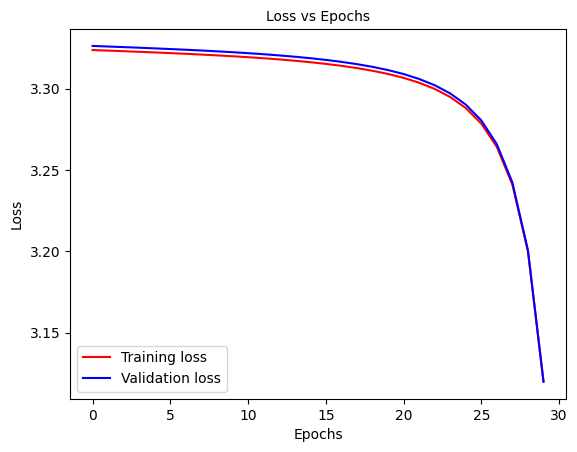

Run num_lay_5 hid_lay_size_128 activ_sigmoid wt_init_He Opt_batchlrn_rate_0.0001


wandb: Agent Starting Run: iailxir5 with config:
wandb: 	batch_size: 64
wandb: 	const_hidden_layer_activation: sigmoid
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 512
wandb: 	epochs: 10
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: batch


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [01:20<00:00,  8.03s/it]


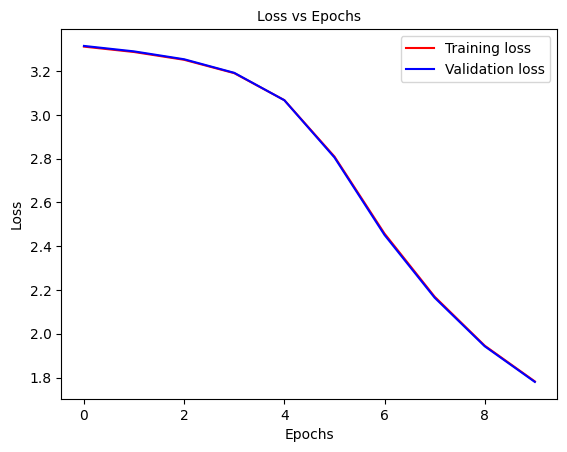

Run num_lay_3 hid_lay_size_512 activ_sigmoid wt_init_xavier Opt_batchlrn_rate_0.0001


wandb: Agent Starting Run: m18o2pwl with config:
wandb: 	batch_size: 32
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 16
wandb: 	epochs: 30
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: nadam


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.48it/s]


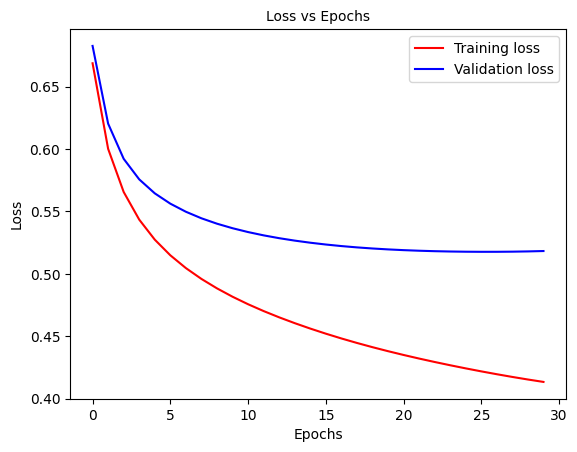

Run num_lay_4 hid_lay_size_16 activ_tanh wt_init_He Opt_nadamlrn_rate_0.001


wandb: Agent Starting Run: 78xqs0eb with config:
wandb: 	batch_size: 32
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 128
wandb: 	epochs: 30
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam


 40%|█████████████████████████████████▏                                                 | 12/30 [00:40<01:00,  3.36s/it]

Early stopping at epoch:  12 reverting to epoch  7


 40%|█████████████████████████████████▏                                                 | 12/30 [00:44<01:07,  3.73s/it]


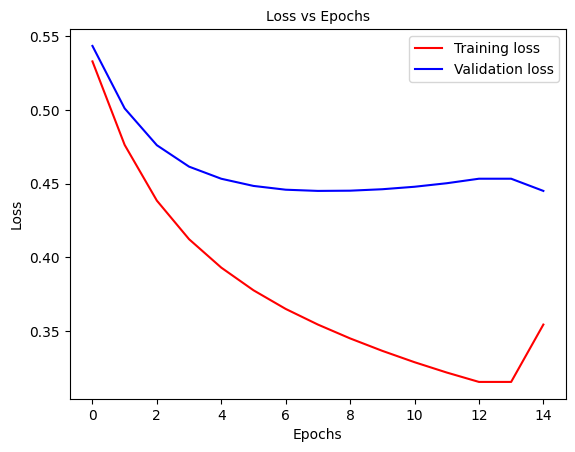

Run num_lay_5 hid_lay_size_128 activ_tanh wt_init_xavier Opt_adamlrn_rate_0.001


wandb: Agent Starting Run: 77ueuanh with config:
wandb: 	batch_size: 32
wandb: 	const_hidden_layer_activation: sigmoid
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 128
wandb: 	epochs: 40
wandb: 	lamdba: 0.5
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 4
wandb: 	optimizer: rmsprop


 50%|█████████████████████████████████████████▌                                         | 20/40 [01:04<01:04,  3.23s/it]

Early stopping at epoch:  20 reverting to epoch  15


 50%|█████████████████████████████████████████▌                                         | 20/40 [01:09<01:09,  3.47s/it]


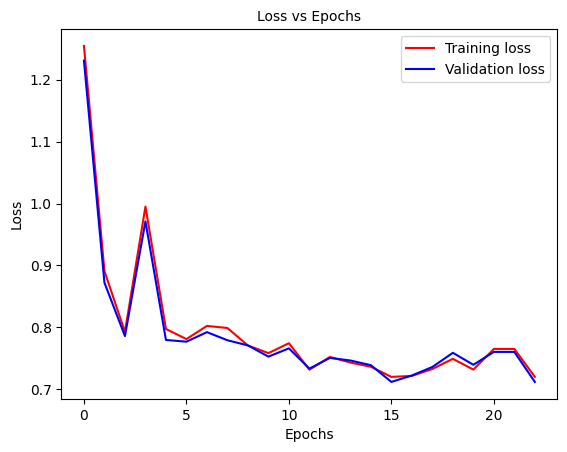

Run num_lay_4 hid_lay_size_128 activ_sigmoid wt_init_He Opt_rmsproplrn_rate_0.01


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1o3juy7m with config:
wandb: 	batch_size: 256
wandb: 	const_hidden_layer_activation: sigmoid
wandb: 	const_hidden_layer_initializations: random
wandb: 	const_hidden_layer_size: 128
wandb: 	epochs: 40
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam


 40%|█████████████████████████████████▏                                                 | 16/40 [00:25<00:38,  1.60s/it]

Early stopping at epoch:  16 reverting to epoch  11


 40%|█████████████████████████████████▏                                                 | 16/40 [00:28<00:42,  1.77s/it]


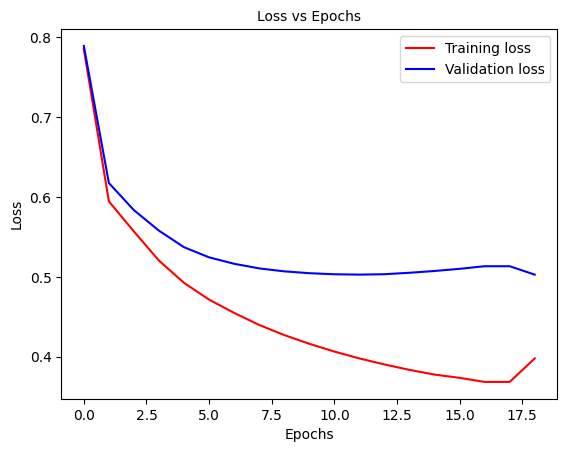

Run num_lay_3 hid_lay_size_128 activ_sigmoid wt_init_random Opt_adamlrn_rate_0.01


wandb: Agent Starting Run: t6zsr8c1 with config:
wandb: 	batch_size: 64
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 128
wandb: 	epochs: 10
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


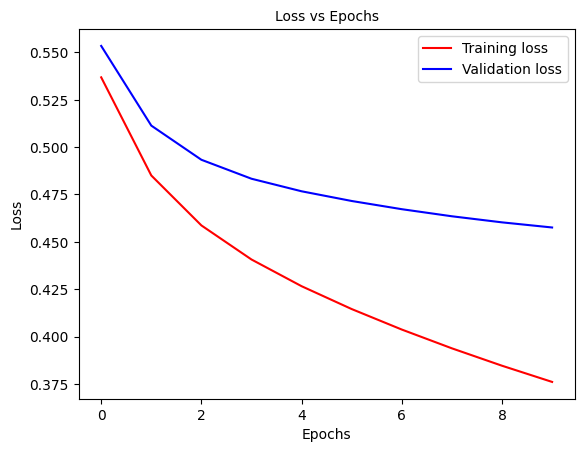

Run num_lay_3 hid_lay_size_128 activ_tanh wt_init_xavier Opt_adamlrn_rate_0.001


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2vacrt63 with config:
wandb: 	batch_size: 256
wandb: 	const_hidden_layer_activation: sigmoid
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 64
wandb: 	epochs: 20
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum


 70%|██████████████████████████████████████████████████████████                         | 14/20 [00:10<00:04,  1.39it/s]

Early stopping at epoch:  14 reverting to epoch  9


 70%|██████████████████████████████████████████████████████████                         | 14/20 [00:11<00:04,  1.23it/s]


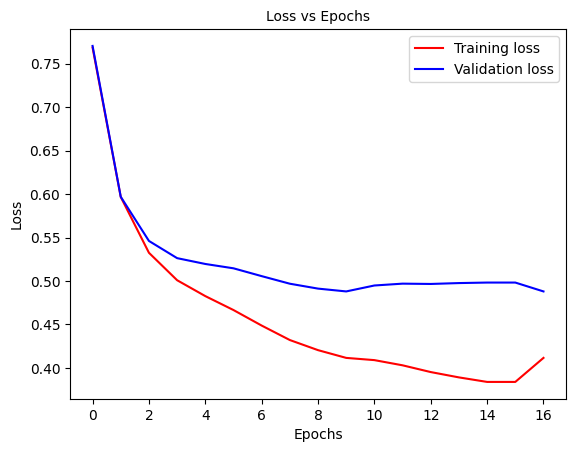

Run num_lay_3 hid_lay_size_64 activ_sigmoid wt_init_He Opt_momentumlrn_rate_0.001


wandb: Agent Starting Run: amr86vck with config:
wandb: 	batch_size: 64
wandb: 	const_hidden_layer_activation: sigmoid
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 16
wandb: 	epochs: 20
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum


 70%|██████████████████████████████████████████████████████████                         | 14/20 [00:05<00:02,  2.70it/s]

Early stopping at epoch:  14 reverting to epoch  9


 70%|██████████████████████████████████████████████████████████                         | 14/20 [00:05<00:02,  2.40it/s]


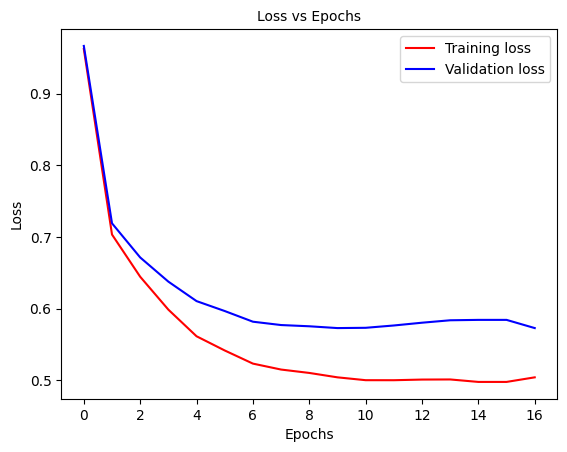

Run num_lay_3 hid_lay_size_16 activ_sigmoid wt_init_He Opt_momentumlrn_rate_0.001


wandb: Agent Starting Run: 4d5d9vn2 with config:
wandb: 	batch_size: 256
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 256
wandb: 	epochs: 40
wandb: 	lamdba: 0.5
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 4
wandb: 	optimizer: nadam


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [01:51<00:00,  2.78s/it]


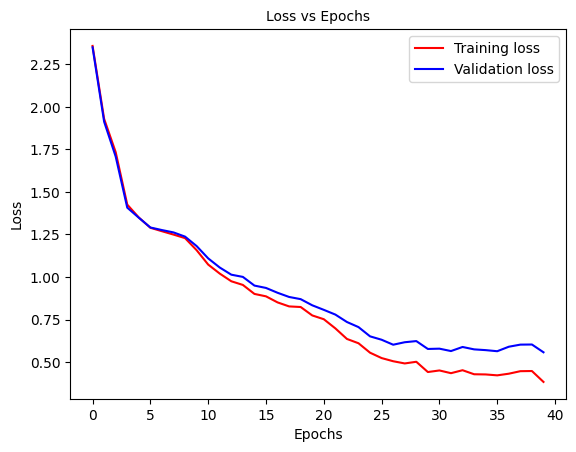

Run num_lay_4 hid_lay_size_256 activ_tanh wt_init_He Opt_nadamlrn_rate_0.01


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zmmibwpv with config:
wandb: 	batch_size: 32
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 64
wandb: 	epochs: 40
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum


 45%|█████████████████████████████████████▎                                             | 18/40 [00:15<00:18,  1.18it/s]

Early stopping at epoch:  18 reverting to epoch  13


 45%|█████████████████████████████████████▎                                             | 18/40 [00:16<00:20,  1.10it/s]


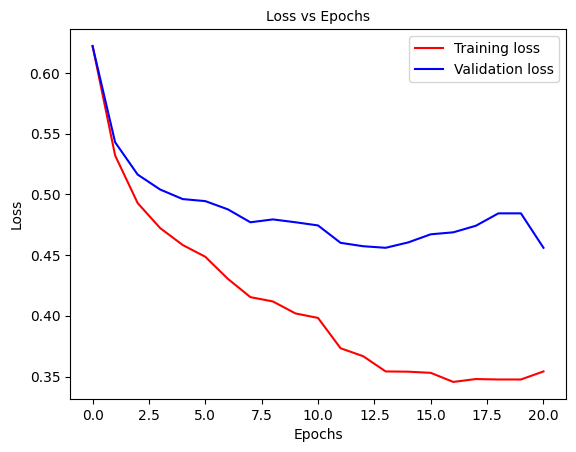

Run num_lay_3 hid_lay_size_64 activ_relu wt_init_xavier Opt_momentumlrn_rate_0.0001


wandb: Agent Starting Run: yn64q2m7 with config:
wandb: 	batch_size: 128
wandb: 	const_hidden_layer_activation: sigmoid
wandb: 	const_hidden_layer_initializations: random
wandb: 	const_hidden_layer_size: 16
wandb: 	epochs: 20
wandb: 	lamdba: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 6
wandb: 	optimizer: momentum


 45%|█████████████████████████████████████▊                                              | 9/20 [00:04<00:04,  2.21it/s]

Early stopping at epoch:  9 reverting to epoch  4


 45%|█████████████████████████████████████▊                                              | 9/20 [00:04<00:05,  1.88it/s]


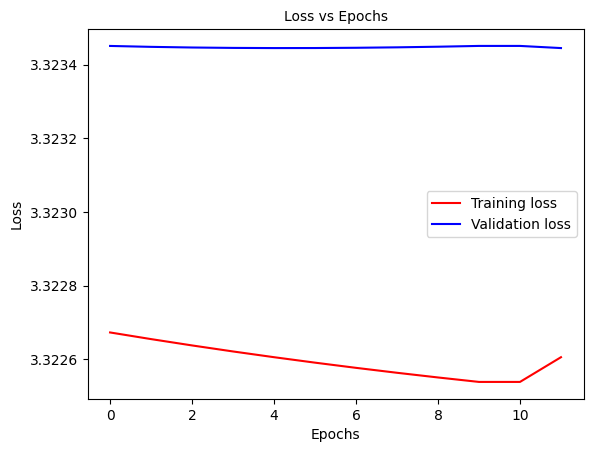

Run num_lay_6 hid_lay_size_16 activ_sigmoid wt_init_random Opt_momentumlrn_rate_0.0001


wandb: Agent Starting Run: 8mglmzlt with config:
wandb: 	batch_size: 64
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 512
wandb: 	epochs: 20
wandb: 	lamdba: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: nesterov


 60%|█████████████████████████████████████████████████▊                                 | 12/20 [02:06<01:23, 10.49s/it]

Early stopping at epoch:  12 reverting to epoch  7


 60%|█████████████████████████████████████████████████▊                                 | 12/20 [02:19<01:33, 11.65s/it]


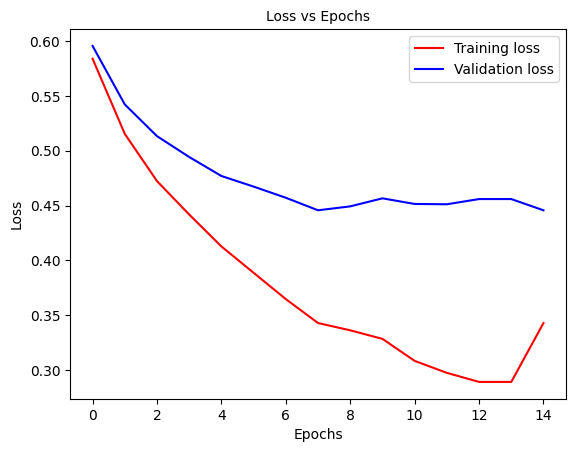

Run num_lay_5 hid_lay_size_512 activ_relu wt_init_xavier Opt_nesterovlrn_rate_0.0001


wandb: Agent Starting Run: trb4x5ub with config:
wandb: 	batch_size: 128
wandb: 	const_hidden_layer_activation: sigmoid
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 32
wandb: 	epochs: 20
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: nadam


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.25it/s]


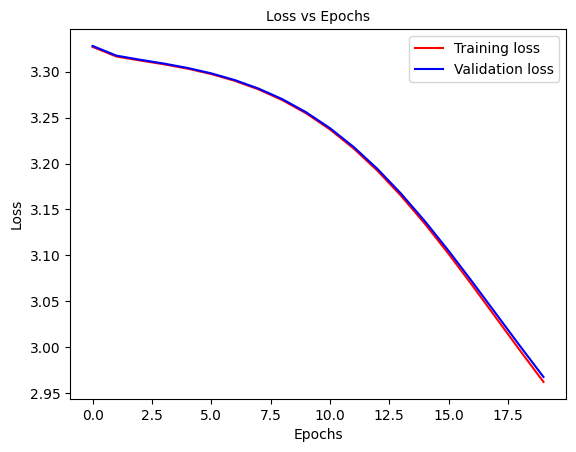

Run num_lay_5 hid_lay_size_32 activ_sigmoid wt_init_xavier Opt_nadamlrn_rate_0.0001


wandb: Agent Starting Run: dv2683zl with config:
wandb: 	batch_size: 64
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 128
wandb: 	epochs: 20
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: rmsprop


 40%|█████████████████████████████████▌                                                  | 8/20 [00:10<00:15,  1.31s/it]

Early stopping at epoch:  8 reverting to epoch  3


 40%|█████████████████████████████████▌                                                  | 8/20 [00:12<00:18,  1.55s/it]


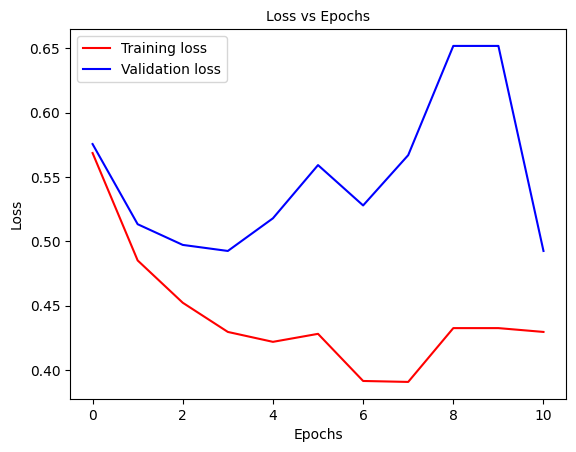

Run num_lay_3 hid_lay_size_128 activ_relu wt_init_xavier Opt_rmsproplrn_rate_0.001


wandb: Agent Starting Run: dmbi4wbo with config:
wandb: 	batch_size: 32
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 512
wandb: 	epochs: 30
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: momentum


  0%|                                                                                            | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_2806300/3245883194.py:43: RuntimeWarning: overflow encountered in matmul
  self.a=self.b+np.matmul(self.W,inputs)
/tmp/ipykernel_2806300/3245883194.py:43: RuntimeWarning: invalid value encountered in matmul
  self.a=self.b+np.matmul(self.W,inputs)
  0%|                                                                                            | 0/30 [00:08<?, ?it/s]


Run dmbi4wbo errored: AttributeError("'optimizers_wandb' object has no attribute 'patience'")
wandb: ERROR Run dmbi4wbo errored: AttributeError("'optimizers_wandb' object has no attribute 'patience'")
wandb: Agent Starting Run: 26390yxp with config:
wandb: 	batch_size: 256
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 256
wandb: 	epochs: 40
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: nesterov


 15%|████████████▌                                                                       | 6/40 [00:07<00:42,  1.24s/it]

Early stopping at epoch:  6 reverting to epoch  1


 15%|████████████▌                                                                       | 6/40 [00:09<00:54,  1.59s/it]


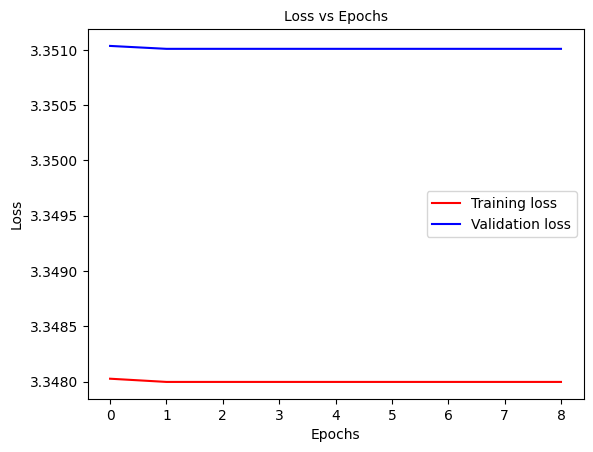

Run num_lay_3 hid_lay_size_256 activ_relu wt_init_xavier Opt_nesterovlrn_rate_0.01


wandb: Agent Starting Run: 3nqbk8bh with config:
wandb: 	batch_size: 32
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 16
wandb: 	epochs: 20
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 6
wandb: 	optimizer: batch


 35%|█████████████████████████████▍                                                      | 7/20 [00:03<00:05,  2.31it/s]

Early stopping at epoch:  7 reverting to epoch  2


 35%|█████████████████████████████▍                                                      | 7/20 [00:03<00:06,  1.89it/s]


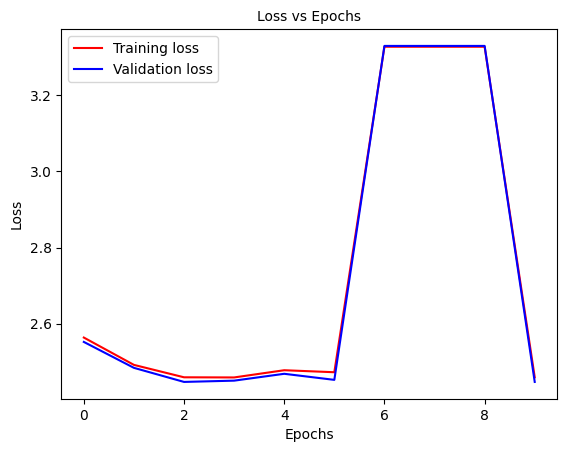

Run num_lay_6 hid_lay_size_16 activ_relu wt_init_He Opt_batchlrn_rate_0.01


wandb: Agent Starting Run: 1is3qqga with config:
wandb: 	batch_size: 64
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 128
wandb: 	epochs: 10
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: nesterov


 60%|██████████████████████████████████████████████████▍                                 | 6/10 [00:10<00:07,  1.76s/it]

Early stopping at epoch:  6 reverting to epoch  1


 60%|██████████████████████████████████████████████████▍                                 | 6/10 [00:13<00:08,  2.20s/it]


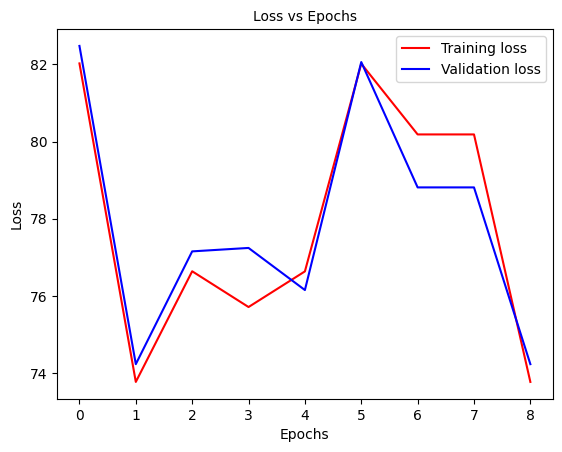

Run num_lay_5 hid_lay_size_128 activ_tanh wt_init_xavier Opt_nesterovlrn_rate_0.01


wandb: Agent Starting Run: u1edf8hp with config:
wandb: 	batch_size: 64
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 16
wandb: 	epochs: 40
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: nadam


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [00:19<00:00,  2.04it/s]


Run num_lay_5 hid_lay_size_16 activ_relu wt_init_He Opt_nadamlrn_rate_0.0001


wandb: Agent Starting Run: 6t40xxyf with config:
wandb: 	batch_size: 128
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 32
wandb: 	epochs: 30
wandb: 	lamdba: 0.5
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: momentum


 37%|██████████████████████████████▍                                                    | 11/30 [00:04<00:07,  2.56it/s]

Early stopping at epoch:  11 reverting to epoch  6


 37%|██████████████████████████████▍                                                    | 11/30 [00:04<00:08,  2.21it/s]


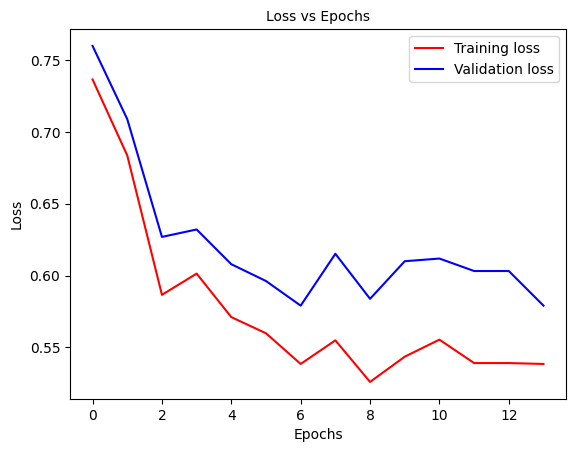

Run num_lay_4 hid_lay_size_32 activ_tanh wt_init_xavier Opt_momentumlrn_rate_0.001


wandb: Agent Starting Run: snfy3298 with config:
wandb: 	batch_size: 128
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 64
wandb: 	epochs: 10
wandb: 	lamdba: 0.5
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: momentum


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.63it/s]


Run num_lay_4 hid_lay_size_64 activ_tanh wt_init_xavier Opt_momentumlrn_rate_0.001


wandb: Agent Starting Run: es6i3mzj with config:
wandb: 	batch_size: 64
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 16
wandb: 	epochs: 40
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: batch


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.82it/s]


Run num_lay_3 hid_lay_size_16 activ_tanh wt_init_xavier Opt_batchlrn_rate_0.0001


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rcjp5nsg with config:
wandb: 	batch_size: 256
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: random
wandb: 	const_hidden_layer_size: 32
wandb: 	epochs: 10
wandb: 	lamdba: 0.5
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: nesterov


 60%|██████████████████████████████████████████████████▍                                 | 6/10 [00:01<00:01,  3.24it/s]

Early stopping at epoch:  6 reverting to epoch  1


 60%|██████████████████████████████████████████████████▍                                 | 6/10 [00:02<00:01,  2.49it/s]


Run num_lay_5 hid_lay_size_32 activ_relu wt_init_random Opt_nesterovlrn_rate_0.01


wandb: Agent Starting Run: 7107qk8e with config:
wandb: 	batch_size: 128
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: random
wandb: 	const_hidden_layer_size: 512
wandb: 	epochs: 30
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: nadam


 43%|███████████████████████████████████▉                                               | 13/30 [06:45<14:07, 49.85s/it]

Early stopping at epoch:  13 reverting to epoch  8


 43%|███████████████████████████████████▉                                               | 13/30 [08:10<10:41, 37.76s/it]


Run num_lay_5 hid_lay_size_512 activ_relu wt_init_random Opt_nadamlrn_rate_0.001


wandb: Agent Starting Run: ris88416 with config:
wandb: 	batch_size: 64
wandb: 	const_hidden_layer_activation: sigmoid
wandb: 	const_hidden_layer_initializations: random
wandb: 	const_hidden_layer_size: 64
wandb: 	epochs: 30
wandb: 	lamdba: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 6
wandb: 	optimizer: adam


 57%|███████████████████████████████████████████████                                    | 17/30 [00:30<00:23,  1.83s/it]

Early stopping at epoch:  17 reverting to epoch  12


 57%|███████████████████████████████████████████████                                    | 17/30 [00:33<00:25,  1.98s/it]


Run num_lay_6 hid_lay_size_64 activ_sigmoid wt_init_random Opt_adamlrn_rate_0.0001


wandb: Agent Starting Run: yeuirvi5 with config:
wandb: 	batch_size: 128
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 256
wandb: 	epochs: 30
wandb: 	lamdba: 0.5
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: nadam


 37%|██████████████████████████████▍                                                    | 11/30 [00:44<01:17,  4.07s/it]

Early stopping at epoch:  11 reverting to epoch  6


 37%|██████████████████████████████▍                                                    | 11/30 [00:50<01:27,  4.59s/it]


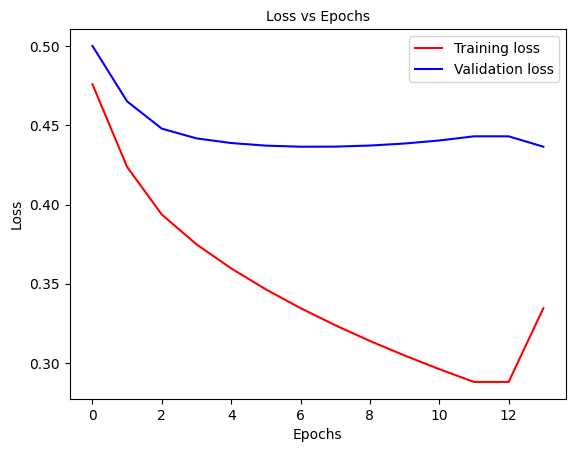

Run num_lay_5 hid_lay_size_256 activ_tanh wt_init_He Opt_nadamlrn_rate_0.001


wandb: Agent Starting Run: 2bf96sw0 with config:
wandb: 	batch_size: 256
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 256
wandb: 	epochs: 20
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: momentum


 50%|█████████████████████████████████████████▌                                         | 10/20 [00:22<00:22,  2.25s/it]

Early stopping at epoch:  10 reverting to epoch  5


 50%|█████████████████████████████████████████▌                                         | 10/20 [00:26<00:26,  2.62s/it]


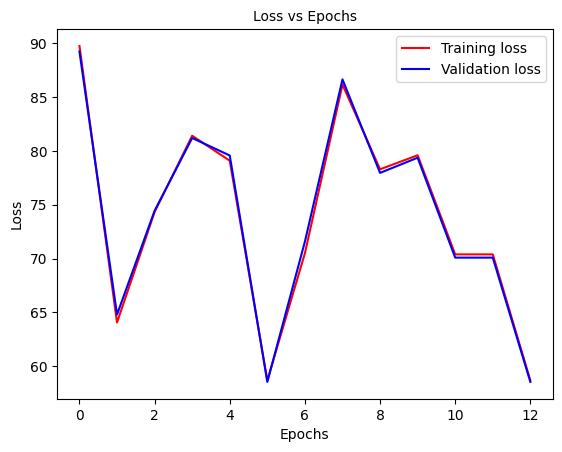

Run num_lay_4 hid_lay_size_256 activ_tanh wt_init_xavier Opt_momentumlrn_rate_0.001


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gerj5ttp with config:
wandb: 	batch_size: 64
wandb: 	const_hidden_layer_activation: sigmoid
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 512
wandb: 	epochs: 10
wandb: 	lamdba: 0.5
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 6
wandb: 	optimizer: nesterov


 50%|██████████████████████████████████████████                                          | 5/10 [01:31<01:31, 18.27s/it]

Early stopping at epoch:  5 reverting to epoch  0


 50%|██████████████████████████████████████████                                          | 5/10 [01:57<01:57, 23.56s/it]


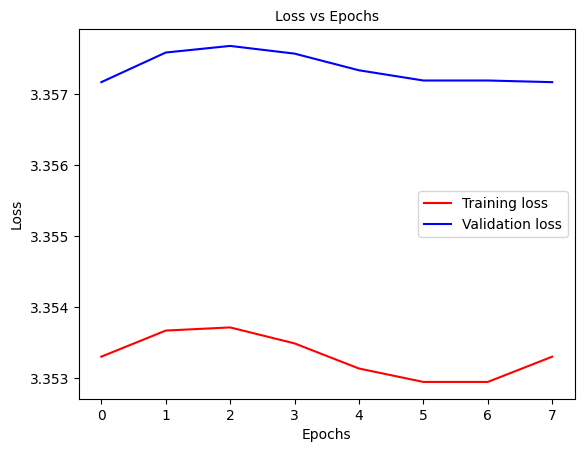

Run num_lay_6 hid_lay_size_512 activ_sigmoid wt_init_He Opt_nesterovlrn_rate_0.01


wandb: Agent Starting Run: 310f1k74 with config:
wandb: 	batch_size: 128
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 128
wandb: 	epochs: 10
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.07it/s]


Run num_lay_3 hid_lay_size_128 activ_tanh wt_init_xavier Opt_momentumlrn_rate_0.0001


wandb: Agent Starting Run: tt4qg1je with config:
wandb: 	batch_size: 256
wandb: 	const_hidden_layer_activation: sigmoid
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 256
wandb: 	epochs: 30
wandb: 	lamdba: 0.5
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: momentum


 23%|███████████████████▌                                                                | 7/30 [00:31<01:42,  4.47s/it]

Early stopping at epoch:  7 reverting to epoch  2


 23%|███████████████████▌                                                                | 7/30 [00:38<02:08,  5.57s/it]


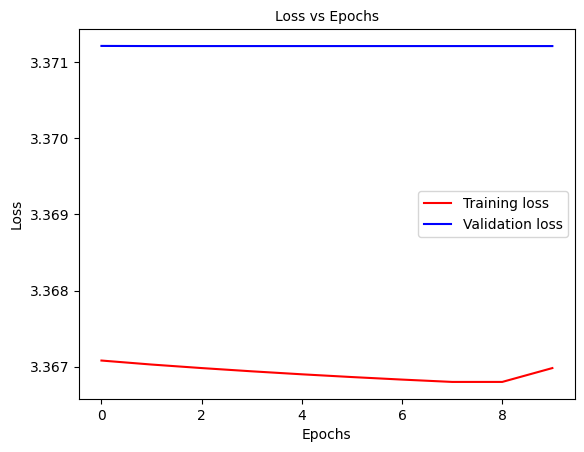

Run num_lay_5 hid_lay_size_256 activ_sigmoid wt_init_xavier Opt_momentumlrn_rate_0.01


wandb: Agent Starting Run: ywe7mxa2 with config:
wandb: 	batch_size: 256
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 512
wandb: 	epochs: 30
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: batch


 27%|██████████████████████▍                                                             | 8/30 [00:52<02:25,  6.62s/it]

Early stopping at epoch:  8 reverting to epoch  3


 27%|██████████████████████▍                                                             | 8/30 [01:03<02:53,  7.88s/it]


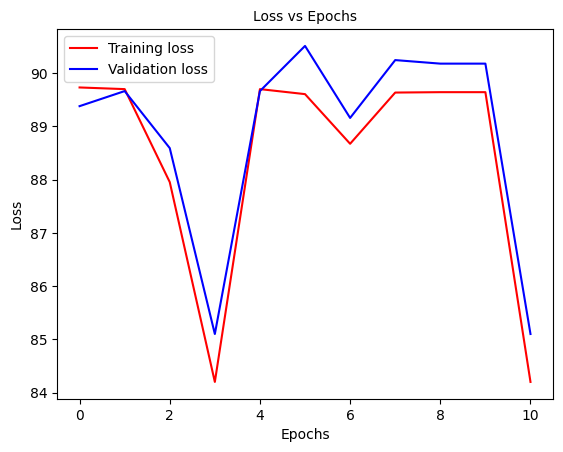

Run num_lay_5 hid_lay_size_512 activ_tanh wt_init_xavier Opt_batchlrn_rate_0.01


wandb: Agent Starting Run: m8pjq8dd with config:
wandb: 	batch_size: 64
wandb: 	const_hidden_layer_activation: sigmoid
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 16
wandb: 	epochs: 20
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: momentum


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.31it/s]


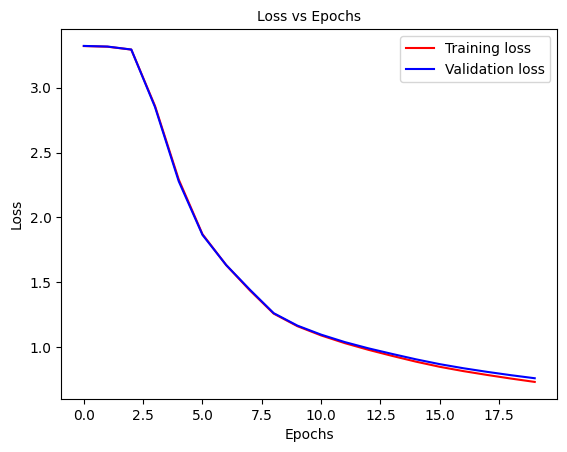

Run num_lay_4 hid_lay_size_16 activ_sigmoid wt_init_xavier Opt_momentumlrn_rate_0.0001


wandb: Agent Starting Run: lv66mm4n with config:
wandb: 	batch_size: 64
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 128
wandb: 	epochs: 30
wandb: 	lamdba: 0.5
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 6
wandb: 	optimizer: nadam


 53%|████████████████████████████████████████████▎                                      | 16/30 [00:42<00:37,  2.69s/it]

Early stopping at epoch:  16 reverting to epoch  11


 53%|████████████████████████████████████████████▎                                      | 16/30 [00:46<00:40,  2.92s/it]


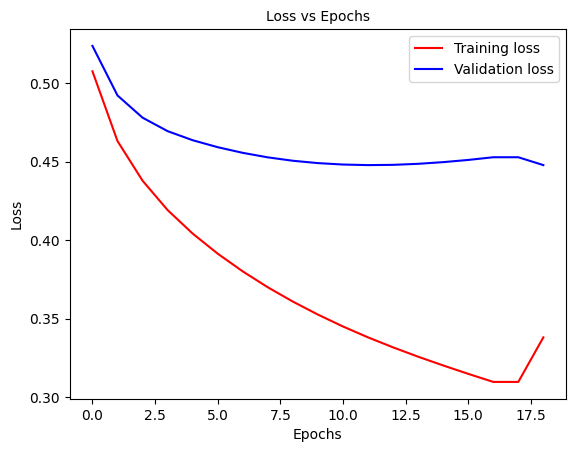

Run num_lay_6 hid_lay_size_128 activ_tanh wt_init_xavier Opt_nadamlrn_rate_0.001


wandb: Agent Starting Run: bstqoqms with config:
wandb: 	batch_size: 128
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 128
wandb: 	epochs: 40
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: adam


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [00:46<00:00,  1.17s/it]


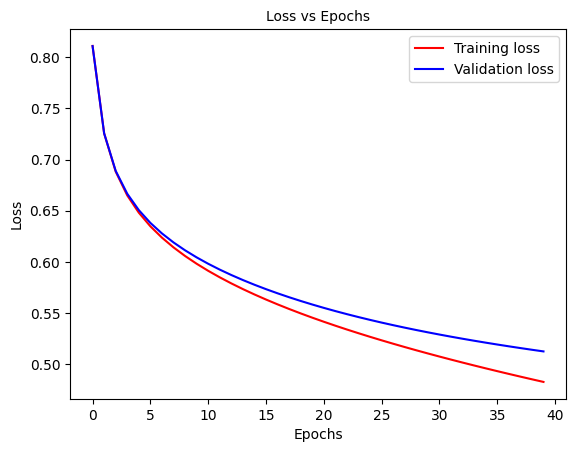

Run num_lay_3 hid_lay_size_128 activ_tanh wt_init_xavier Opt_adamlrn_rate_0.0001


wandb: Agent Starting Run: b81p6gqd with config:
wandb: 	batch_size: 32
wandb: 	const_hidden_layer_activation: sigmoid
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 32
wandb: 	epochs: 20
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 6
wandb: 	optimizer: batch


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:21<00:00,  1.06s/it]


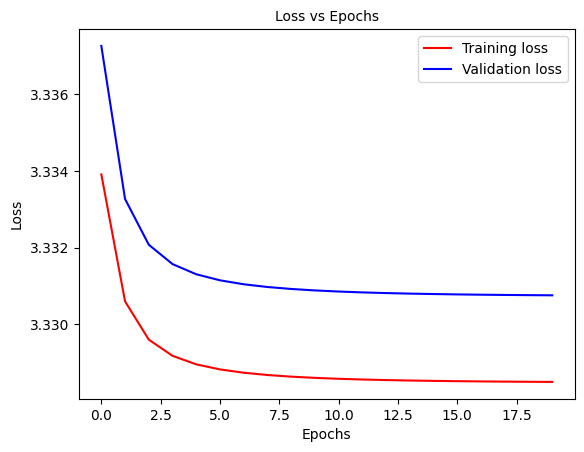

Run num_lay_6 hid_lay_size_32 activ_sigmoid wt_init_xavier Opt_batchlrn_rate_0.01


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4t0b39xi with config:
wandb: 	batch_size: 32
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 256
wandb: 	epochs: 40
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: batch


 38%|███████████████████████████████▏                                                   | 15/40 [00:49<01:21,  3.27s/it]

Early stopping at epoch:  15 reverting to epoch  10


 38%|███████████████████████████████▏                                                   | 15/40 [00:53<01:29,  3.57s/it]


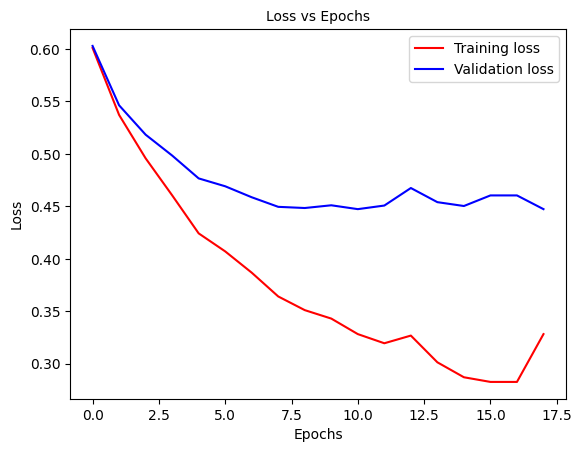

Run num_lay_4 hid_lay_size_256 activ_relu wt_init_xavier Opt_batchlrn_rate_0.001


wandb: Agent Starting Run: s3pg6l1x with config:
wandb: 	batch_size: 32
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 128
wandb: 	epochs: 40
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: batch


 38%|███████████████████████████████▏                                                   | 15/40 [00:29<00:48,  1.94s/it]

Early stopping at epoch:  15 reverting to epoch  10


 38%|███████████████████████████████▏                                                   | 15/40 [00:31<00:53,  2.13s/it]


Run num_lay_5 hid_lay_size_128 activ_tanh wt_init_xavier Opt_batchlrn_rate_0.001


wandb: Agent Starting Run: iu62seoi with config:
wandb: 	batch_size: 64
wandb: 	const_hidden_layer_activation: sigmoid
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 256
wandb: 	epochs: 30
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: nesterov


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [02:52<00:00,  5.75s/it]


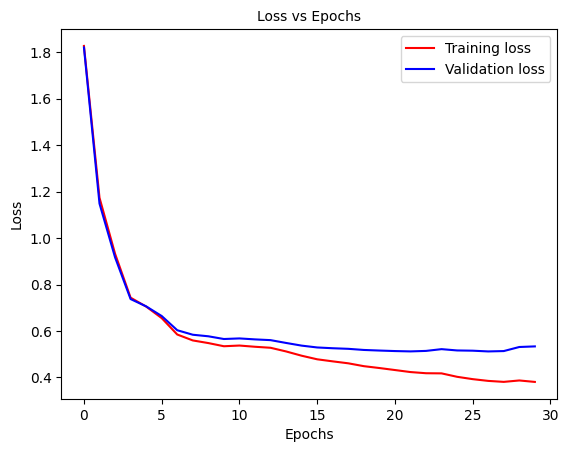

Run num_lay_5 hid_lay_size_256 activ_sigmoid wt_init_He Opt_nesterovlrn_rate_0.001


wandb: Agent Starting Run: t5mg11ap with config:
wandb: 	batch_size: 256
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: random
wandb: 	const_hidden_layer_size: 512
wandb: 	epochs: 30
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: nesterov


 77%|███████████████████████████████████████████████████████████████▋                   | 23/30 [01:54<00:35,  5.02s/it]

Early stopping at epoch:  23 reverting to epoch  18


 77%|███████████████████████████████████████████████████████████████▋                   | 23/30 [02:01<00:36,  5.29s/it]


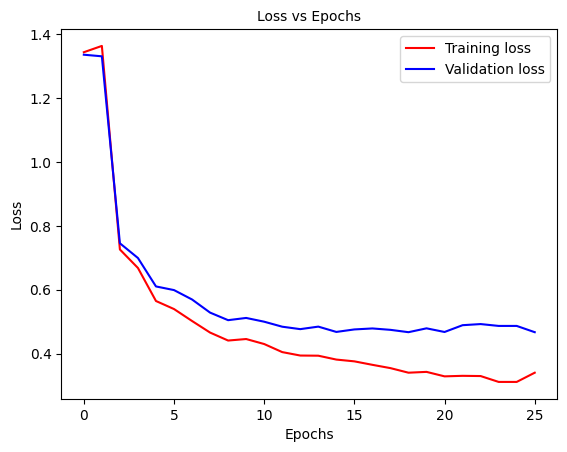

Run num_lay_4 hid_lay_size_512 activ_relu wt_init_random Opt_nesterovlrn_rate_0.0001


wandb: Agent Starting Run: 38n0s320 with config:
wandb: 	batch_size: 64
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: random
wandb: 	const_hidden_layer_size: 64
wandb: 	epochs: 20
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: batch


 25%|█████████████████████                                                               | 5/20 [00:03<00:10,  1.44it/s]

Early stopping at epoch:  5 reverting to epoch  0


 25%|█████████████████████                                                               | 5/20 [00:04<00:13,  1.09it/s]


Run num_lay_5 hid_lay_size_64 activ_relu wt_init_random Opt_batchlrn_rate_0.001


wandb: Agent Starting Run: l0hi61qy with config:
wandb: 	batch_size: 256
wandb: 	const_hidden_layer_activation: sigmoid
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 16
wandb: 	epochs: 30
wandb: 	lamdba: 0.5
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 6
wandb: 	optimizer: momentum


 93%|█████████████████████████████████████████████████████████████████████████████▍     | 28/30 [00:12<00:00,  2.28it/s]

Early stopping at epoch:  28 reverting to epoch  23


 93%|█████████████████████████████████████████████████████████████████████████████▍     | 28/30 [00:12<00:00,  2.16it/s]


Run num_lay_6 hid_lay_size_16 activ_sigmoid wt_init_xavier Opt_momentumlrn_rate_0.001


wandb: Agent Starting Run: 58ep3kj1 with config:
wandb: 	batch_size: 256
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 16
wandb: 	epochs: 40
wandb: 	lamdba: 0.5
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 6
wandb: 	optimizer: nesterov


 12%|██████████▌                                                                         | 5/40 [00:01<00:10,  3.33it/s]

Early stopping at epoch:  5 reverting to epoch  0


 12%|██████████▌                                                                         | 5/40 [00:02<00:14,  2.39it/s]


Run num_lay_6 hid_lay_size_16 activ_tanh wt_init_xavier Opt_nesterovlrn_rate_0.001


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3q22usif with config:
wandb: 	batch_size: 128
wandb: 	const_hidden_layer_activation: sigmoid
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 64
wandb: 	epochs: 40
wandb: 	lamdba: 0.5
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 4
wandb: 	optimizer: rmsprop


 28%|██████████████████████▊                                                            | 11/40 [00:11<00:30,  1.06s/it]

Early stopping at epoch:  11 reverting to epoch  6


 28%|██████████████████████▊                                                            | 11/40 [00:13<00:35,  1.23s/it]


Run num_lay_4 hid_lay_size_64 activ_sigmoid wt_init_He Opt_rmsproplrn_rate_0.01


wandb: Agent Starting Run: f82sae9i with config:
wandb: 	batch_size: 64
wandb: 	const_hidden_layer_activation: sigmoid
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 256
wandb: 	epochs: 20
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [01:39<00:00,  4.95s/it]


Run num_lay_3 hid_lay_size_256 activ_sigmoid wt_init_He Opt_adamlrn_rate_0.001


wandb: Agent Starting Run: lewy8kbx with config:
wandb: 	batch_size: 128
wandb: 	const_hidden_layer_activation: sigmoid
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 256
wandb: 	epochs: 20
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: rmsprop


 95%|██████████████████████████████████████████████████████████████████████████████▊    | 19/20 [01:07<00:03,  3.52s/it]

Early stopping at epoch:  19 reverting to epoch  14


 95%|██████████████████████████████████████████████████████████████████████████████▊    | 19/20 [01:12<00:03,  3.83s/it]


Run num_lay_3 hid_lay_size_256 activ_sigmoid wt_init_He Opt_rmsproplrn_rate_0.001


wandb: Agent Starting Run: toz64ms0 with config:
wandb: 	batch_size: 32
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: random
wandb: 	const_hidden_layer_size: 128
wandb: 	epochs: 40
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: nadam


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [02:07<00:00,  3.20s/it]


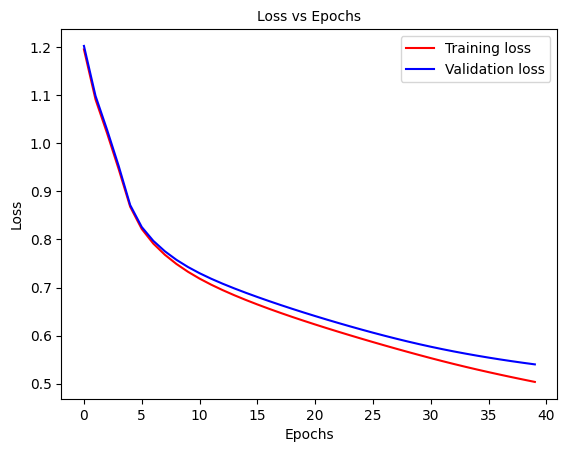

Run num_lay_4 hid_lay_size_128 activ_tanh wt_init_random Opt_nadamlrn_rate_0.0001


wandb: Agent Starting Run: t20qzm5j with config:
wandb: 	batch_size: 128
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: random
wandb: 	const_hidden_layer_size: 32
wandb: 	epochs: 40
wandb: 	lamdba: 0.5
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: nadam


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.78it/s]


Run num_lay_5 hid_lay_size_32 activ_tanh wt_init_random Opt_nadamlrn_rate_0.001


wandb: Agent Starting Run: wymgbhm2 with config:
wandb: 	batch_size: 32
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: random
wandb: 	const_hidden_layer_size: 16
wandb: 	epochs: 10
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 6
wandb: 	optimizer: nesterov


 50%|██████████████████████████████████████████                                          | 5/10 [00:02<00:02,  1.89it/s]

Early stopping at epoch:  5 reverting to epoch  0


 50%|██████████████████████████████████████████                                          | 5/10 [00:03<00:03,  1.47it/s]


Run num_lay_6 hid_lay_size_16 activ_relu wt_init_random Opt_nesterovlrn_rate_0.01


wandb: Agent Starting Run: edhq0rro with config:
wandb: 	batch_size: 32
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 64
wandb: 	epochs: 30
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: nesterov


 47%|██████████████████████████████████████▋                                            | 14/30 [00:18<00:21,  1.36s/it]

Early stopping at epoch:  14 reverting to epoch  9


 47%|██████████████████████████████████████▋                                            | 14/30 [00:20<00:23,  1.49s/it]


Run num_lay_5 hid_lay_size_64 activ_tanh wt_init_He Opt_nesterovlrn_rate_0.001


wandb: Agent Starting Run: 4ogar9ns with config:
wandb: 	batch_size: 32
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: random
wandb: 	const_hidden_layer_size: 64
wandb: 	epochs: 40
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: rmsprop


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [00:43<00:00,  1.08s/it]


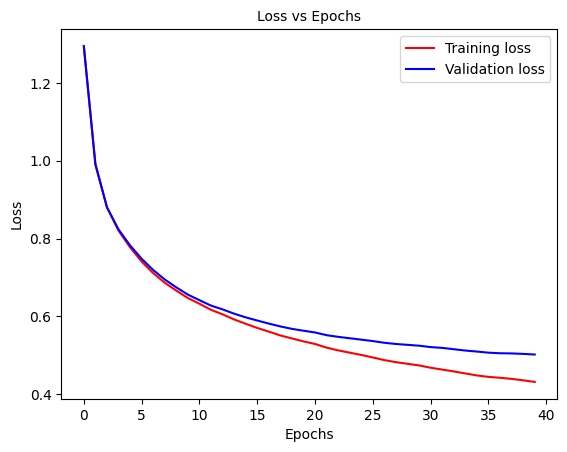

Run num_lay_3 hid_lay_size_64 activ_relu wt_init_random Opt_rmsproplrn_rate_0.0001


wandb: Agent Starting Run: uafol7o2 with config:
wandb: 	batch_size: 256
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: random
wandb: 	const_hidden_layer_size: 512
wandb: 	epochs: 40
wandb: 	lamdba: 0.5
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: nadam


 40%|█████████████████████████████████▏                                                 | 16/40 [02:23<03:34,  8.94s/it]

Early stopping at epoch:  16 reverting to epoch  11


 40%|█████████████████████████████████▏                                                 | 16/40 [02:35<03:53,  9.72s/it]


Run num_lay_5 hid_lay_size_512 activ_tanh wt_init_random Opt_nadamlrn_rate_0.01


wandb: Agent Starting Run: q3zj1ijp with config:
wandb: 	batch_size: 256
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 32
wandb: 	epochs: 10
wandb: 	lamdba: 0.5
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: rmsprop


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.51it/s]


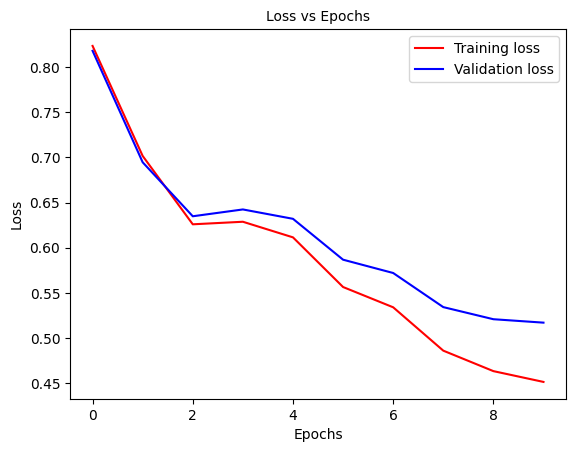

Run num_lay_5 hid_lay_size_32 activ_tanh wt_init_He Opt_rmsproplrn_rate_0.001


wandb: Agent Starting Run: 7us3yj5s with config:
wandb: 	batch_size: 64
wandb: 	const_hidden_layer_activation: sigmoid
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 64
wandb: 	epochs: 10
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: momentum


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.33s/it]


Run num_lay_5 hid_lay_size_64 activ_sigmoid wt_init_He Opt_momentumlrn_rate_0.01


wandb: Agent Starting Run: w9iikmkk with config:
wandb: 	batch_size: 256
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: random
wandb: 	const_hidden_layer_size: 16
wandb: 	epochs: 10
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 6
wandb: 	optimizer: nesterov


 50%|██████████████████████████████████████████                                          | 5/10 [00:01<00:01,  3.28it/s]

Early stopping at epoch:  5 reverting to epoch  0


 50%|██████████████████████████████████████████                                          | 5/10 [00:02<00:02,  2.36it/s]


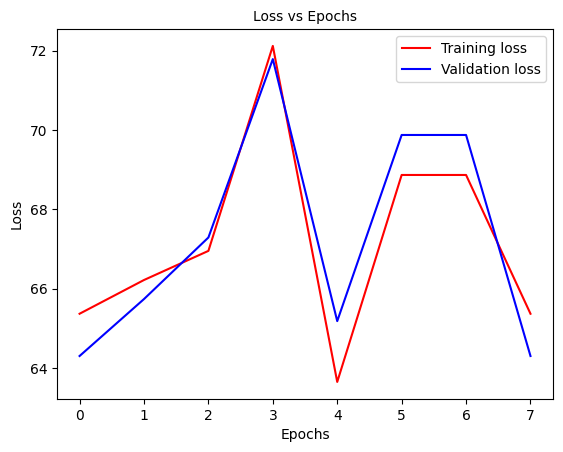

Run num_lay_6 hid_lay_size_16 activ_tanh wt_init_random Opt_nesterovlrn_rate_0.01


wandb: Agent Starting Run: ptrmupdt with config:
wandb: 	batch_size: 32
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 128
wandb: 	epochs: 20
wandb: 	lamdba: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 6
wandb: 	optimizer: nadam


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [01:47<00:00,  5.37s/it]


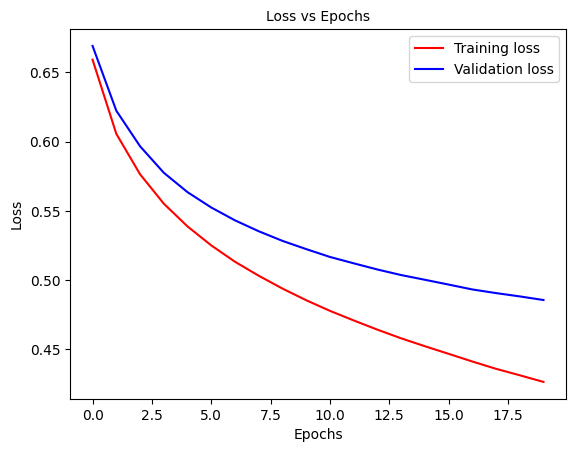

Run num_lay_6 hid_lay_size_128 activ_relu wt_init_He Opt_nadamlrn_rate_0.0001


wandb: Agent Starting Run: fdky6re9 with config:
wandb: 	batch_size: 256
wandb: 	const_hidden_layer_activation: sigmoid
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 512
wandb: 	epochs: 20
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: rmsprop


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [03:55<00:00, 11.76s/it]


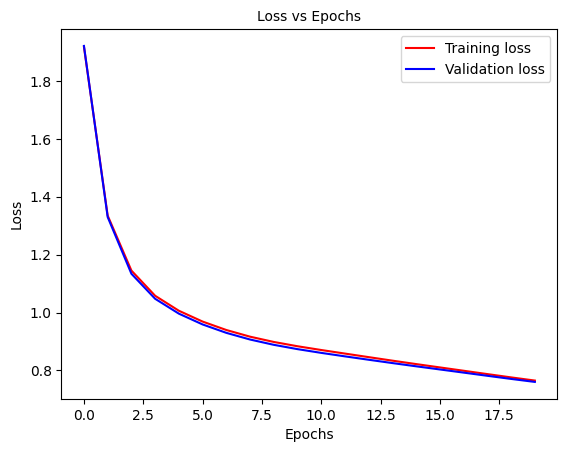

Run num_lay_5 hid_lay_size_512 activ_sigmoid wt_init_He Opt_rmsproplrn_rate_0.0001


wandb: Agent Starting Run: 0ei0y6mb with config:
wandb: 	batch_size: 64
wandb: 	const_hidden_layer_activation: sigmoid
wandb: 	const_hidden_layer_initializations: random
wandb: 	const_hidden_layer_size: 128
wandb: 	epochs: 20
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 6
wandb: 	optimizer: momentum


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:59<00:00,  2.96s/it]


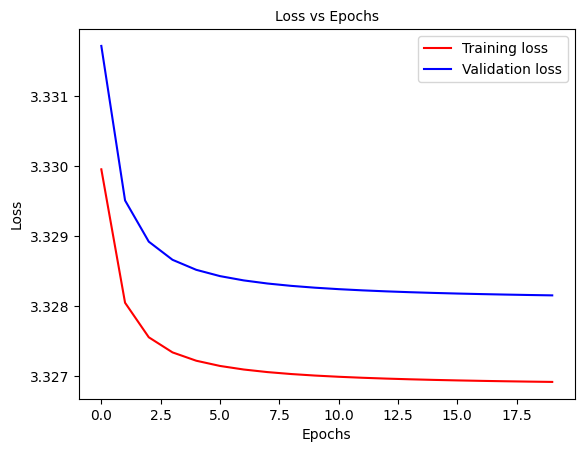

Run num_lay_6 hid_lay_size_128 activ_sigmoid wt_init_random Opt_momentumlrn_rate_0.001


wandb: Agent Starting Run: pyar46ay with config:
wandb: 	batch_size: 256
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 16
wandb: 	epochs: 10
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: nadam


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.26it/s]


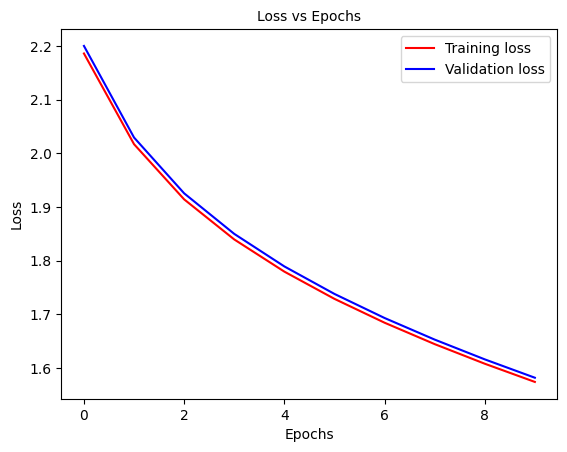

Run num_lay_5 hid_lay_size_16 activ_tanh wt_init_He Opt_nadamlrn_rate_0.0001


wandb: Agent Starting Run: rekzpep2 with config:
wandb: 	batch_size: 32
wandb: 	const_hidden_layer_activation: sigmoid
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 256
wandb: 	epochs: 30
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 6
wandb: 	optimizer: nesterov


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [04:19<00:00,  8.66s/it]


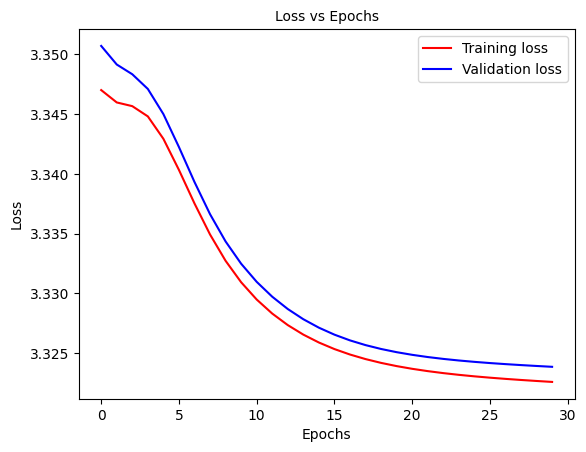

Run num_lay_6 hid_lay_size_256 activ_sigmoid wt_init_xavier Opt_nesterovlrn_rate_0.0001


wandb: Agent Starting Run: 64ef7mnp with config:
wandb: 	batch_size: 64
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 64
wandb: 	epochs: 20
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: rmsprop


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.22it/s]


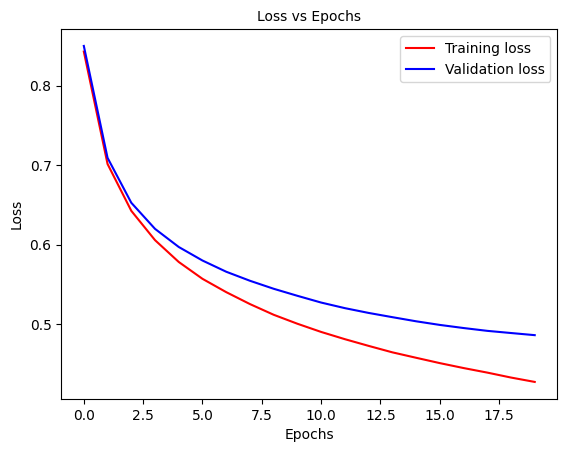

Run num_lay_4 hid_lay_size_64 activ_relu wt_init_xavier Opt_rmsproplrn_rate_0.0001


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3vj4njsv with config:
wandb: 	batch_size: 32
wandb: 	const_hidden_layer_activation: sigmoid
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 16
wandb: 	epochs: 30
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: adam


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.44it/s]


Run num_lay_3 hid_lay_size_16 activ_sigmoid wt_init_xavier Opt_adamlrn_rate_0.0001


wandb: Agent Starting Run: mu1xzvt1 with config:
wandb: 	batch_size: 128
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 128
wandb: 	epochs: 40
wandb: 	lamdba: 0.5
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam


 30%|████████████████████████▉                                                          | 12/40 [00:11<00:27,  1.00it/s]

Early stopping at epoch:  12 reverting to epoch  7


 30%|████████████████████████▉                                                          | 12/40 [00:13<00:31,  1.12s/it]


Run num_lay_3 hid_lay_size_128 activ_relu wt_init_xavier Opt_adamlrn_rate_0.01


wandb: Agent Starting Run: egq4jrk2 with config:
wandb: 	batch_size: 128
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 16
wandb: 	epochs: 10
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: nadam


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.84it/s]


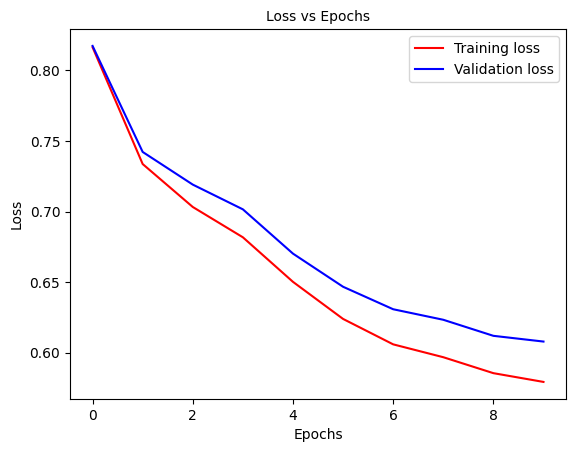

Run num_lay_3 hid_lay_size_16 activ_relu wt_init_He Opt_nadamlrn_rate_0.01


wandb: Agent Starting Run: d6z2m2w3 with config:
wandb: 	batch_size: 32
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: random
wandb: 	const_hidden_layer_size: 512
wandb: 	epochs: 30
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 6
wandb: 	optimizer: adam


 30%|█████████████████████████▏                                                          | 9/30 [09:07<26:41, 76.27s/it]

Early stopping at epoch:  9 reverting to epoch  4


 30%|█████████████████████████▏                                                          | 9/30 [10:33<24:38, 70.39s/it]


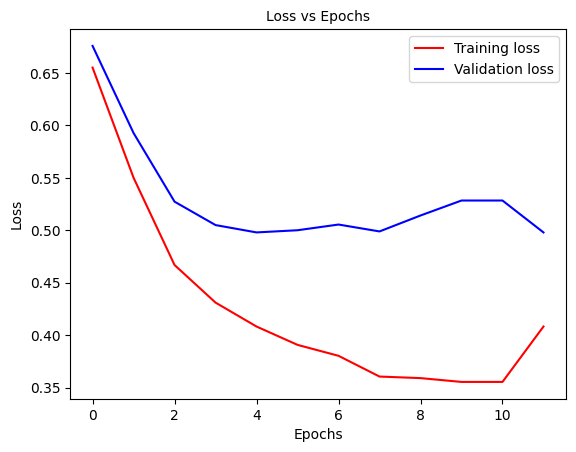

Run num_lay_6 hid_lay_size_512 activ_relu wt_init_random Opt_adamlrn_rate_0.001


wandb: Agent Starting Run: 42p4w6pn with config:
wandb: 	batch_size: 128
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 16
wandb: 	epochs: 40
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 6
wandb: 	optimizer: nesterov


 12%|██████████▌                                                                         | 5/40 [00:01<00:08,  3.95it/s]

Early stopping at epoch:  5 reverting to epoch  0


 12%|██████████▌                                                                         | 5/40 [00:01<00:12,  2.85it/s]


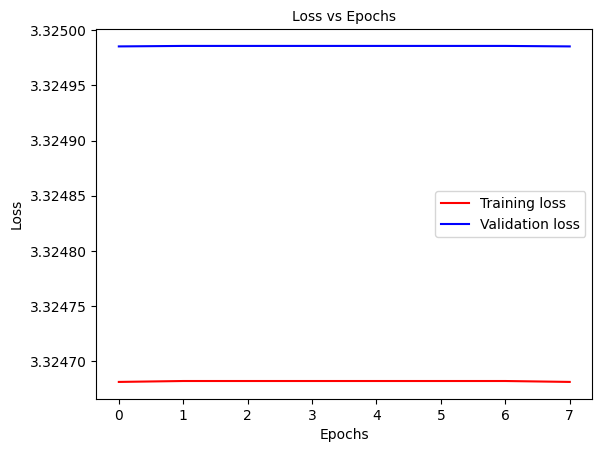

Run num_lay_6 hid_lay_size_16 activ_relu wt_init_xavier Opt_nesterovlrn_rate_0.001


wandb: Agent Starting Run: kuoulols with config:
wandb: 	batch_size: 32
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 128
wandb: 	epochs: 20
wandb: 	lamdba: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: momentum


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:44<00:00,  2.21s/it]


Run num_lay_5 hid_lay_size_128 activ_tanh wt_init_xavier Opt_momentumlrn_rate_0.0001


wandb: Agent Starting Run: wgxn2c49 with config:
wandb: 	batch_size: 256
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 32
wandb: 	epochs: 30
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 4
wandb: 	optimizer: batch


 43%|███████████████████████████████████▉                                               | 13/30 [00:04<00:05,  2.99it/s]

Early stopping at epoch:  13 reverting to epoch  8


 43%|███████████████████████████████████▉                                               | 13/30 [00:04<00:06,  2.61it/s]


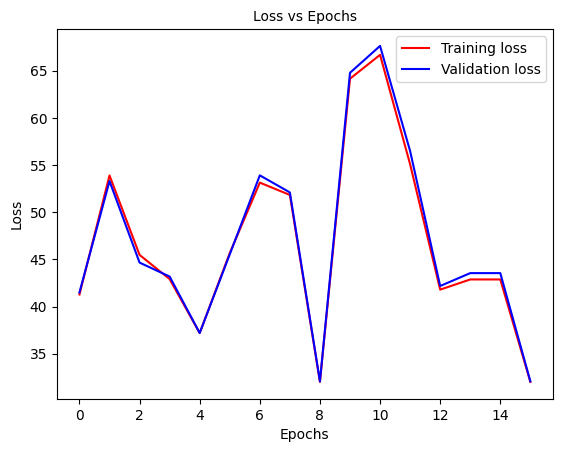

Run num_lay_4 hid_lay_size_32 activ_tanh wt_init_He Opt_batchlrn_rate_0.01


wandb: Agent Starting Run: wgwcf93s with config:
wandb: 	batch_size: 256
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 256
wandb: 	epochs: 40
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 4
wandb: 	optimizer: adam


 38%|███████████████████████████████▏                                                   | 15/40 [00:40<01:06,  2.67s/it]

Early stopping at epoch:  15 reverting to epoch  10


 38%|███████████████████████████████▏                                                   | 15/40 [00:44<01:13,  2.94s/it]


Run num_lay_4 hid_lay_size_256 activ_tanh wt_init_He Opt_adamlrn_rate_0.01


wandb: Agent Starting Run: x6q7dyw7 with config:
wandb: 	batch_size: 256
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: random
wandb: 	const_hidden_layer_size: 32
wandb: 	epochs: 20
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 6
wandb: 	optimizer: nesterov


 45%|█████████████████████████████████████▊                                              | 9/20 [00:03<00:03,  2.98it/s]

Early stopping at epoch:  9 reverting to epoch  4


 45%|█████████████████████████████████████▊                                              | 9/20 [00:03<00:04,  2.46it/s]


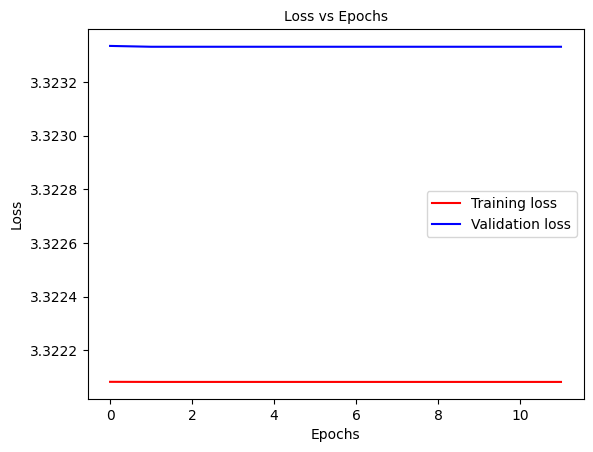

Run num_lay_6 hid_lay_size_32 activ_relu wt_init_random Opt_nesterovlrn_rate_0.0001


wandb: Agent Starting Run: 58ozzuxz with config:
wandb: 	batch_size: 32
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: random
wandb: 	const_hidden_layer_size: 128
wandb: 	epochs: 20
wandb: 	lamdba: 0.5
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:50<00:00,  2.52s/it]


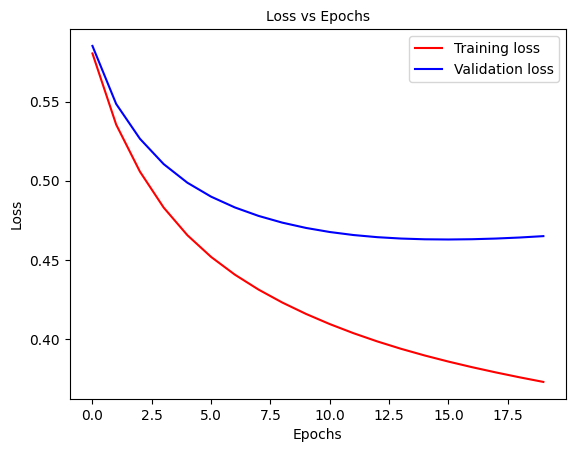

Run num_lay_3 hid_lay_size_128 activ_tanh wt_init_random Opt_adamlrn_rate_0.001


wandb: Agent Starting Run: 4okz9rmy with config:
wandb: 	batch_size: 256
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: random
wandb: 	const_hidden_layer_size: 16
wandb: 	epochs: 30
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: nadam


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.24it/s]


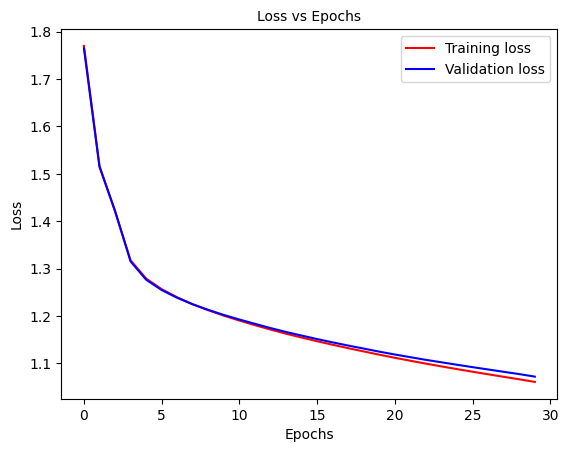

Run num_lay_4 hid_lay_size_16 activ_relu wt_init_random Opt_nadamlrn_rate_0.001


wandb: Agent Starting Run: k5mq7y1a with config:
wandb: 	batch_size: 256
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 256
wandb: 	epochs: 10
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: nadam


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:26<00:00,  2.68s/it]


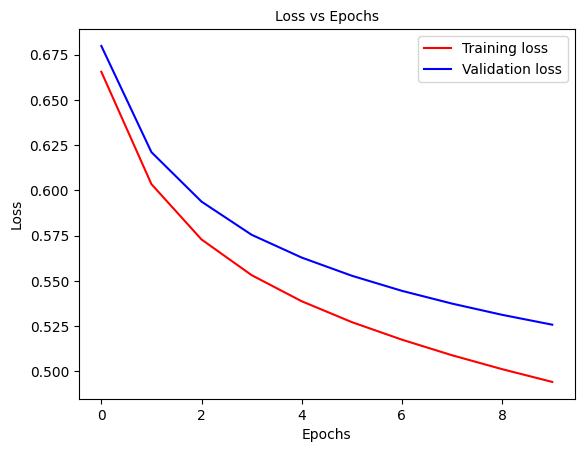

Run num_lay_5 hid_lay_size_256 activ_relu wt_init_He Opt_nadamlrn_rate_0.0001


wandb: Agent Starting Run: rq1nvm9q with config:
wandb: 	batch_size: 32
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 32
wandb: 	epochs: 10
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: rmsprop


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.71it/s]


Run num_lay_3 hid_lay_size_32 activ_relu wt_init_He Opt_rmsproplrn_rate_0.0001


wandb: Agent Starting Run: jgq0ex01 with config:
wandb: 	batch_size: 32
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: random
wandb: 	const_hidden_layer_size: 128
wandb: 	epochs: 30
wandb: 	lamdba: 0.5
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 6
wandb: 	optimizer: nesterov


 17%|██████████████                                                                      | 5/30 [00:13<01:09,  2.77s/it]

Early stopping at epoch:  5 reverting to epoch  0


 17%|██████████████                                                                      | 5/30 [00:17<01:28,  3.54s/it]


Run num_lay_6 hid_lay_size_128 activ_tanh wt_init_random Opt_nesterovlrn_rate_0.01


wandb: Agent Starting Run: g3hnnhso with config:
wandb: 	batch_size: 256
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: random
wandb: 	const_hidden_layer_size: 128
wandb: 	epochs: 30
wandb: 	lamdba: 0.5
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam


 53%|████████████████████████████████████████████▎                                      | 16/30 [00:12<00:10,  1.30it/s]

Early stopping at epoch:  16 reverting to epoch  11


 53%|████████████████████████████████████████████▎                                      | 16/30 [00:13<00:11,  1.18it/s]


Run num_lay_3 hid_lay_size_128 activ_relu wt_init_random Opt_adamlrn_rate_0.01


wandb: Agent Starting Run: aehr3jpk with config:
wandb: 	batch_size: 32
wandb: 	const_hidden_layer_activation: sigmoid
wandb: 	const_hidden_layer_initializations: random
wandb: 	const_hidden_layer_size: 128
wandb: 	epochs: 10
wandb: 	lamdba: 0.5
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: nesterov


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:33<00:00,  3.38s/it]


Run num_lay_5 hid_lay_size_128 activ_sigmoid wt_init_random Opt_nesterovlrn_rate_0.01


wandb: Agent Starting Run: j2u99dp9 with config:
wandb: 	batch_size: 64
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 16
wandb: 	epochs: 40
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: adam


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [00:16<00:00,  2.49it/s]


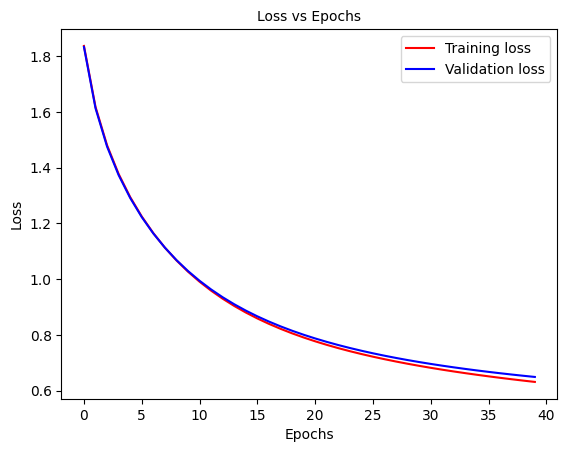

Run num_lay_4 hid_lay_size_16 activ_tanh wt_init_He Opt_adamlrn_rate_0.0001


wandb: Agent Starting Run: 6nmeglc3 with config:
wandb: 	batch_size: 256
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: random
wandb: 	const_hidden_layer_size: 64
wandb: 	epochs: 40
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 6
wandb: 	optimizer: momentum


 18%|██████████████▋                                                                     | 7/40 [00:05<00:23,  1.39it/s]

Early stopping at epoch:  7 reverting to epoch  2


 18%|██████████████▋                                                                     | 7/40 [00:06<00:29,  1.11it/s]


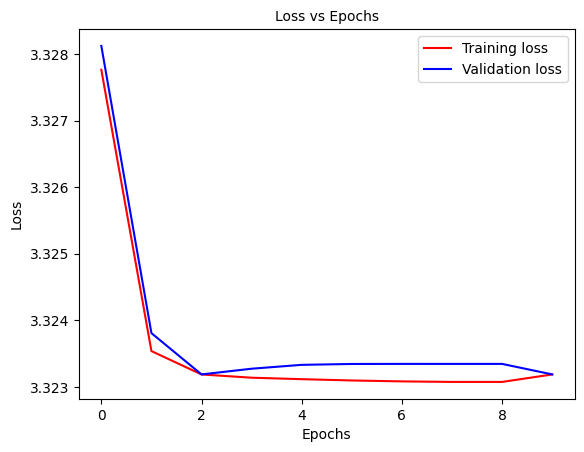

Run num_lay_6 hid_lay_size_64 activ_tanh wt_init_random Opt_momentumlrn_rate_0.001


wandb: Agent Starting Run: fnjhp3zf with config:
wandb: 	batch_size: 128
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 64
wandb: 	epochs: 30
wandb: 	lamdba: 0.5
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: batch


 80%|██████████████████████████████████████████████████████████████████▍                | 24/30 [00:14<00:03,  1.61it/s]

Early stopping at epoch:  24 reverting to epoch  19


 80%|██████████████████████████████████████████████████████████████████▍                | 24/30 [00:15<00:03,  1.51it/s]


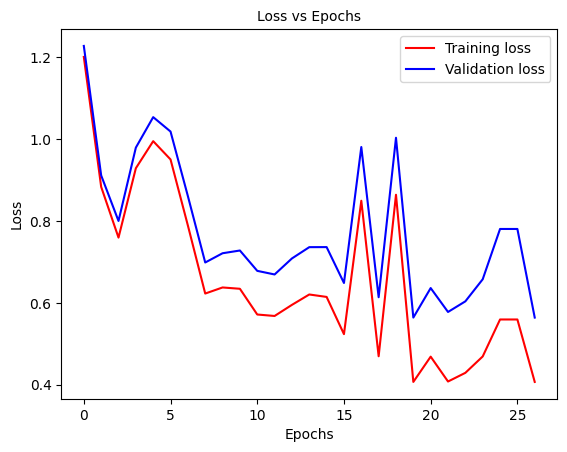

Run num_lay_5 hid_lay_size_64 activ_relu wt_init_xavier Opt_batchlrn_rate_0.001


wandb: Agent Starting Run: nmclef77 with config:
wandb: 	batch_size: 32
wandb: 	const_hidden_layer_activation: sigmoid
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 64
wandb: 	epochs: 20
wandb: 	lamdba: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: nesterov


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.33s/it]


Run num_lay_3 hid_lay_size_64 activ_sigmoid wt_init_xavier Opt_nesterovlrn_rate_0.0001


wandb: Agent Starting Run: ln1lm4vj with config:
wandb: 	batch_size: 128
wandb: 	const_hidden_layer_activation: sigmoid
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 512
wandb: 	epochs: 30
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam


 53%|████████████████████████████████████████████▎                                      | 16/30 [03:59<03:29, 14.99s/it]

Early stopping at epoch:  16 reverting to epoch  11


 53%|████████████████████████████████████████████▎                                      | 16/30 [04:20<03:48, 16.31s/it]


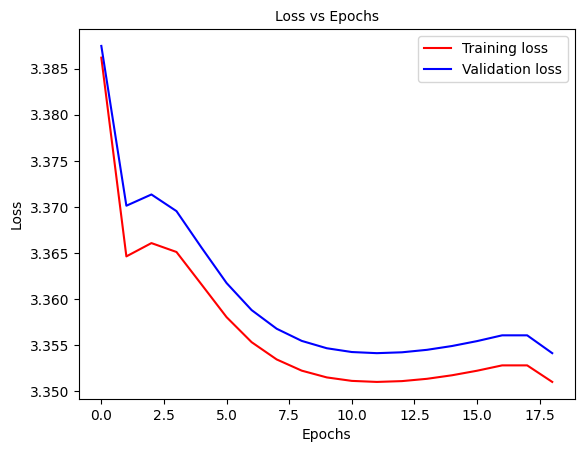

Run num_lay_5 hid_lay_size_512 activ_sigmoid wt_init_xavier Opt_adamlrn_rate_0.01


wandb: Agent Starting Run: 5ig6tjn9 with config:
wandb: 	batch_size: 256
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 512
wandb: 	epochs: 20
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: nesterov


 30%|█████████████████████████▏                                                          | 6/20 [00:26<01:01,  4.39s/it]

Early stopping at epoch:  6 reverting to epoch  1


 30%|█████████████████████████▏                                                          | 6/20 [00:32<01:16,  5.50s/it]


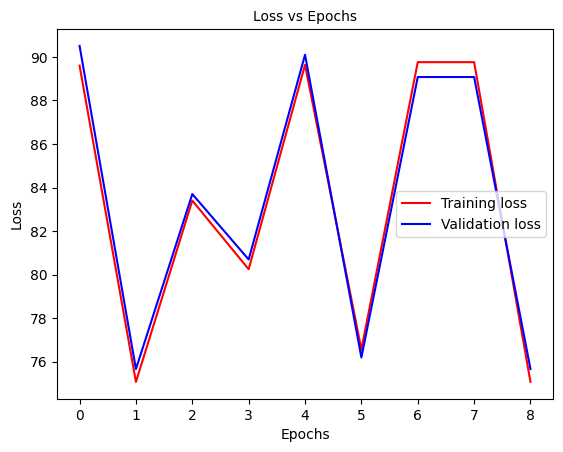

Run num_lay_3 hid_lay_size_512 activ_tanh wt_init_He Opt_nesterovlrn_rate_0.001


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: woktazsh with config:
wandb: 	batch_size: 256
wandb: 	const_hidden_layer_activation: sigmoid
wandb: 	const_hidden_layer_initializations: random
wandb: 	const_hidden_layer_size: 128
wandb: 	epochs: 40
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 4
wandb: 	optimizer: momentum


 12%|██████████▌                                                                         | 5/40 [00:08<01:02,  1.78s/it]

Early stopping at epoch:  5 reverting to epoch  0


 12%|██████████▌                                                                         | 5/40 [00:12<01:25,  2.43s/it]


Run num_lay_4 hid_lay_size_128 activ_sigmoid wt_init_random Opt_momentumlrn_rate_0.01


wandb: Agent Starting Run: a029w7sx with config:
wandb: 	batch_size: 64
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: random
wandb: 	const_hidden_layer_size: 32
wandb: 	epochs: 30
wandb: 	lamdba: 0.5
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum


 47%|██████████████████████████████████████▋                                            | 14/30 [00:05<00:06,  2.35it/s]

Early stopping at epoch:  14 reverting to epoch  9


 47%|██████████████████████████████████████▋                                            | 14/30 [00:06<00:07,  2.10it/s]


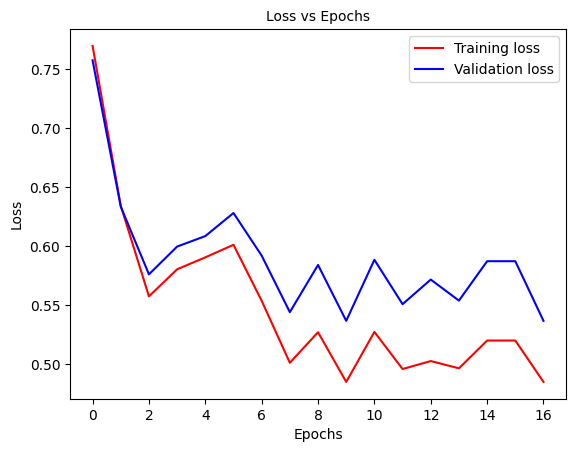

Run num_lay_3 hid_lay_size_32 activ_tanh wt_init_random Opt_momentumlrn_rate_0.001


wandb: Agent Starting Run: lyoeyzp6 with config:
wandb: 	batch_size: 64
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 32
wandb: 	epochs: 20
wandb: 	lamdba: 0.5
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: batch


 95%|██████████████████████████████████████████████████████████████████████████████▊    | 19/20 [00:08<00:00,  2.13it/s]

Early stopping at epoch:  19 reverting to epoch  14


 95%|██████████████████████████████████████████████████████████████████████████████▊    | 19/20 [00:09<00:00,  1.99it/s]


Run num_lay_4 hid_lay_size_32 activ_relu wt_init_xavier Opt_batchlrn_rate_0.001


wandb: Agent Starting Run: lnlo4q94 with config:
wandb: 	batch_size: 128
wandb: 	const_hidden_layer_activation: sigmoid
wandb: 	const_hidden_layer_initializations: random
wandb: 	const_hidden_layer_size: 256
wandb: 	epochs: 20
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: rmsprop


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [01:09<00:00,  3.48s/it]


Run num_lay_3 hid_lay_size_256 activ_sigmoid wt_init_random Opt_rmsproplrn_rate_0.0001


wandb: Agent Starting Run: 5eocyhvk with config:
wandb: 	batch_size: 128
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: random
wandb: 	const_hidden_layer_size: 256
wandb: 	epochs: 40
wandb: 	lamdba: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: nadam


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [02:16<00:00,  3.41s/it]


Run num_lay_4 hid_lay_size_256 activ_tanh wt_init_random Opt_nadamlrn_rate_0.0001


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jjd8qwyr with config:
wandb: 	batch_size: 32
wandb: 	const_hidden_layer_activation: relu
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 256
wandb: 	epochs: 40
wandb: 	lamdba: 0.5
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: nesterov


 12%|██████████▌                                                                         | 5/40 [00:23<02:41,  4.61s/it]

Early stopping at epoch:  5 reverting to epoch  0


 12%|██████████▌                                                                         | 5/40 [00:28<03:22,  5.77s/it]


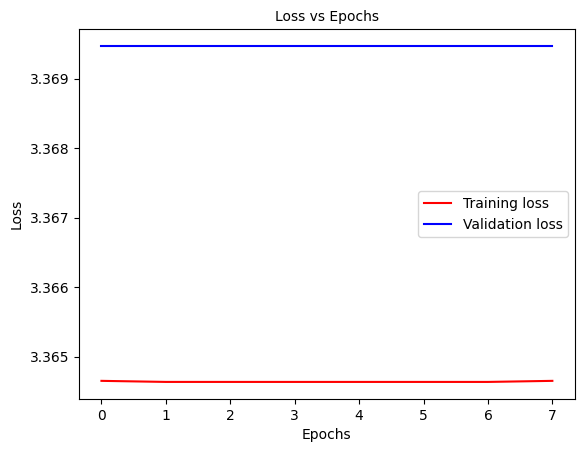

Run num_lay_5 hid_lay_size_256 activ_relu wt_init_xavier Opt_nesterovlrn_rate_0.01


wandb: Agent Starting Run: 5n2q6e32 with config:
wandb: 	batch_size: 256
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: xavier
wandb: 	const_hidden_layer_size: 512
wandb: 	epochs: 30
wandb: 	lamdba: 0.5
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 4
wandb: 	optimizer: adam


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [03:26<00:00,  6.88s/it]


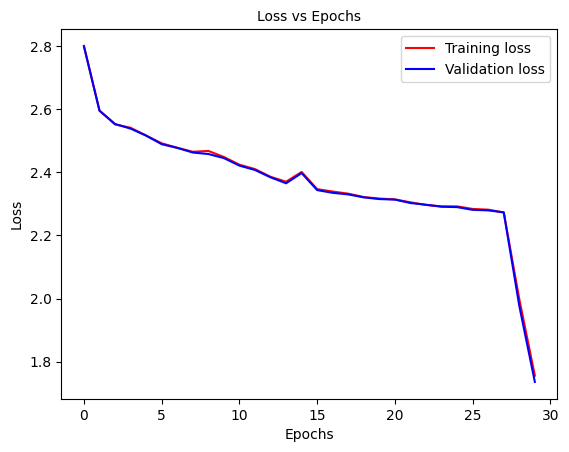

Run num_lay_4 hid_lay_size_512 activ_tanh wt_init_xavier Opt_adamlrn_rate_0.01


wandb: Agent Starting Run: e1ba0srr with config:
wandb: 	batch_size: 64
wandb: 	const_hidden_layer_activation: tanh
wandb: 	const_hidden_layer_initializations: He
wandb: 	const_hidden_layer_size: 256
wandb: 	epochs: 30
wandb: 	lamdba: 0
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: adam


 33%|███████████████████████████▋                                                       | 10/30 [00:44<01:28,  4.41s/it]

Early stopping at epoch:  10 reverting to epoch  5


 33%|███████████████████████████▋                                                       | 10/30 [00:50<01:40,  5.01s/it]


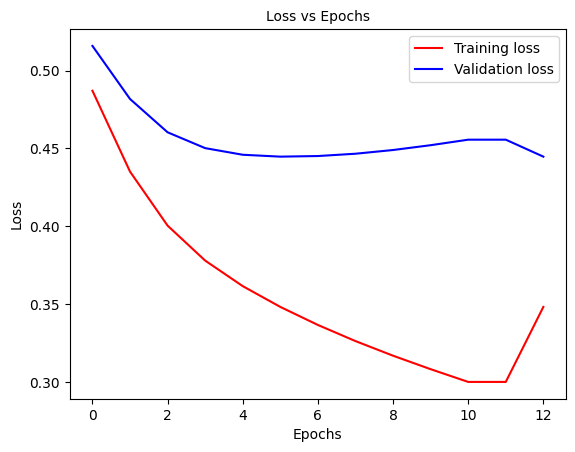

Run num_lay_4 hid_lay_size_256 activ_tanh wt_init_He Opt_adamlrn_rate_0.001


In [16]:
wandb.agent(sweep_id,project='DL-Assign1', function=WandB_sweep, count=150)